In [1]:
import pandas as pd 
import sys
import torch
from torch.utils.data import TensorDataset, DataLoader
import time 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../../duq/')  
import post, pre
import mc_dropout as MC

import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppresses sklearn warning about PCA.. Is this ok?

Device =  cpu


In [2]:
seed = 1234                  # Assign a value to the seed
pre.set_seed(seed)      # Set the seed for 'random', 'np.random', 'torch.manual_seed' and 'torch.cuda.manual_seed_all'

# Importing Data

## Import, Pre-process and Split Data

## Splitting Test Set from Main Corpus

This code imports the full dataset in `csv` format for analysis. 

The user can choose which frequency to predict by changing `y_cols` here. More than one frequency can be in this list, however some of the plotting functions need to be changed slightly. See `MC_Dropout_multi_output.ipynb` for an example of predicting multiple frequencies. 

The column headings (and corresponding indices) are as follows:

| num_x | num_y | num_z | width_x | width_y | width_z | freq1 | freq2 | freq3 | freq4 | freq5 | freq6 |
| :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- |
| [0] | [1] | [2] | [3] | [4] | [5] | [6] | [7] | [8] | [9] | [10] | [11] |

In [3]:
y_cols = [6]             # Which column(s) does the the dependent variable(s) that we're interested in sit? list
x_cols = [0,1,2,3,4,5]   # Which column(s) is the independent variable(s) (features) in? list
component = "n/a"        # this is used if we want to sort and split the data by a particular parameter

# Import the csv file and save as DataFrame
filepath = '../../data/all_data.csv'
df_orig = pd.read_csv(filepath, header=None)
df_orig.columns = ['nbays_x', 'nbays_y', 'nbays_z', 'bay_width_x', 'bay_width_y', 'bay_width_z', 'modal_freq_1', 'modal_freq_2', 'modal_freq_3', 'modal_freq_4', 'modal_freq_5', 'modal_freq_6']

# Calculate the mean and standard deviation of the original dataset
data_mean = df_orig.mean()
data_std = df_orig.std()

# Visualise full dataset in reduced dimensional space 
_, components = post.PCA_transformdata(df_orig.iloc[:,x_cols], return_components=True)

## Split Data into Test, Train, Val

All data within the specified `train_lims_all` gets put into a training set. Then a proportion `val_split` of the training set gets put into a validation set. 

Anything within the regions specified by `ood_lims_in` and `ood_lims_out` goes in the inner OOD and outer OOD regions respectively. These are then combined to make a test set. 

The datasets are then normalised and an additional column is added that contains the L2 distance of each point from the geometric median point. 

Each input parameter (i.e. columns 1 to 6) is plotted in reduced dimensional space for visualisation. 

OOD lower:	835
OOD upper:	195
Train:		929
Test:		863
Val:		104
Unused:		82
Total:		1978 (of 1978)


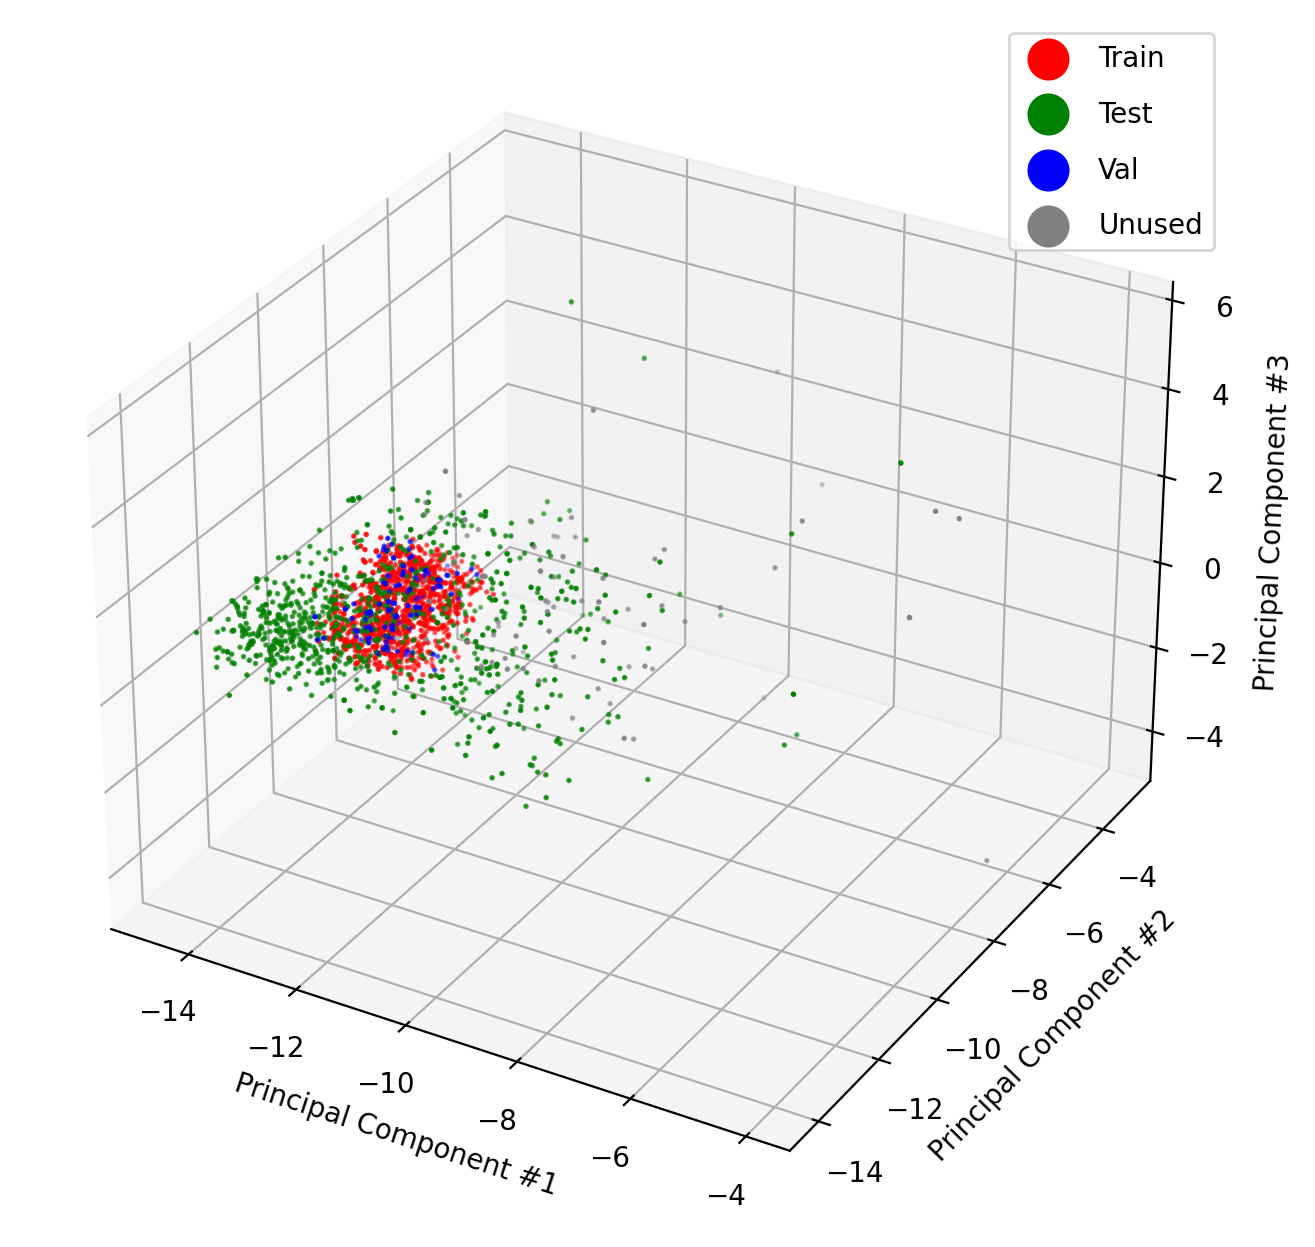

In [4]:
ood_lims_in = [[0., 3.], [0., 3.], [0., 3.], [0., 5.], [0., 5.], [0., 5.]]
train_lims_all = [[3., 10], [3., 10], [3., 10], [5., 10], [5., 10], [5., 10]]
ood_lims_out = [[10, 25], [10, 25], [10, 30], [10, 12], [10, 12], [10, 12]]

TRAIN, VAL, TEST = pre.split_by_bounds(df=df_orig.copy(),
                                 x_cols=x_cols,
                                 y_cols=y_cols,
                                 train_lims_all=train_lims_all,
                                 ood_lims_in=ood_lims_in,
                                 ood_lims_out=ood_lims_out,
                                 data_mean=data_mean, 
                                 data_std=data_std, 
                                 PCA_components=components,
                                 val_split=0.1,
                                 verbose=True,
                                 plots=True,
                                 figsize=(8,8),
                                 dpi=200)
                                      #save_image=True, savename="../reports/final_report_images/splitting_data/manual_bounds.eps", saveformat="eps")

x_train, y_train, train_data, train_indices = TRAIN
x_val, y_val, val_data, val_indices = VAL
x_test, y_test, test_data, test_indices = TEST

y_train_unnorm = pre.unnormalise(y_train,data_mean[y_cols].values,data_std[y_cols].values)
y_val_unnorm = pre.unnormalise(y_val,data_mean[y_cols].values,data_std[y_cols].values)
y_test_unnorm = pre.unnormalise(y_test,data_mean[y_cols].values,data_std[y_cols].values)


## Run quick stats on datasets

These histograms show the distribution of y values (i.e. frequency) in the split datasets. 

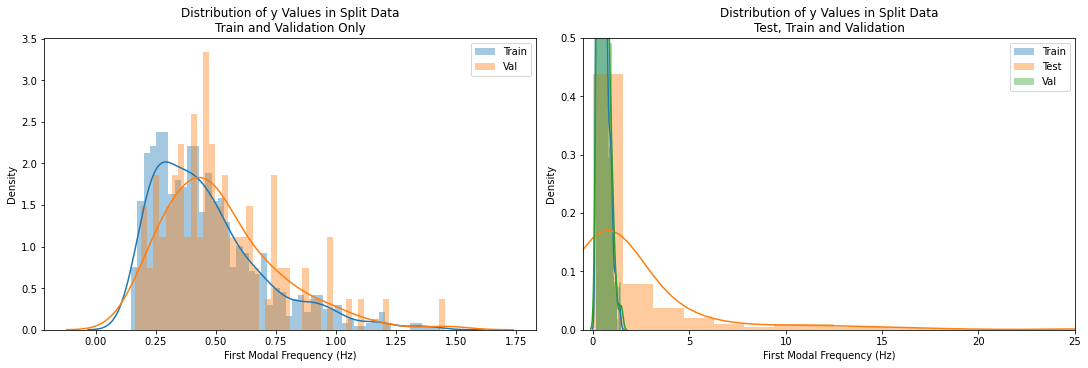

In [5]:
fig, axs = plt.subplots(1,2,constrained_layout=True, figsize=(15,5))

sns.distplot(y_train_unnorm,bins=50,label="Train",ax=axs[0])
sns.distplot(y_val_unnorm,bins=50,label="Val",ax=axs[0])
axs[0].set_title("Distribution of y Values in Split Data\nTrain and Validation Only")
axs[0].set_xlabel("First Modal Frequency (Hz)")
axs[0].legend()

sns.distplot(y_train_unnorm,label="Train",ax=axs[1])
sns.distplot(y_test_unnorm,label="Test",ax=axs[1])
sns.distplot(y_val_unnorm,label="Val",ax=axs[1])
axs[1].set_title("Distribution of y Values in Split Data\nTest, Train and Validation")
axs[1].set_xlabel("First Modal Frequency (Hz)")
axs[1].set_ylim((0,0.5))
axs[1].set_xlim((-0.5,25))
axs[1].legend();

# Neural Network Instantiation and Training

## Define Parameters of the Model

In [6]:
# Save the model so we can load it and perform inference later
#savename = "../trained_models/for_prediction/MC_35"
checkpoint_path = "../../trained_models/for_retraining/MC_Dropout"

parameters = dict(
    # Specific to this method
    drop_prob=0.3,
    num_samples=150,
    
    # Generic Hyperparameters
    num_epochs= 1000,
    batch_size= 50,              # Batch size for training data
    lr=  5e-4,                   # Learning rate
    weight_decay= None,          # Weight decay
    
    # Model architecture
    input_dim= len(x_cols),      # Number of input neurons
    output_dim= len(y_cols),     # Number of output neurons
    num_units= 100,              # Number of neurons per hidden layer
    num_layers=5,
    
    # Data
    y_cols = y_cols,             # Which column(s) contain the dependent variable(s) / label(s) 
    x_cols = x_cols,             # Which column(s) contain the independent variable(s) / feature(s)
    
    # Logigng only
    component = None,            # Which parameter are we sorting by (as an int)? 
    sortby=None,                 # Name of the component we're sorting by (as a string)
    model_name= "MC_Dropout_Final",    # For logging only
    criterion_name= "MSELoss",   # For logging only
    optimiser_name= "Adam",      # For logging only 
    cutoff_percentile = None,    # How much we're splitting from top and bottom of sorted training set for test set 
    val_split=None,              # How much we're splitting from the train set (minus the test set), as a float between 0-1
    seed=seed,                   # Random seed used (for logging only)
    ood_lims_in=ood_lims_in,     # Inner OOD limits
    train_lims_all=train_lims_all, # Training set limits
    ood_lims_out=ood_lims_out    # Outer OOD limits
)

assert parameters['output_dim'] == len(y_cols), f"Please ensure that the number of output neurons is correct! There should be {len(y_cols)}"
assert parameters['input_dim'] == len(x_cols), f"Please ensure that the number of input neurons is correct! There should be {len(x_cols)}" 

## If using Weights and Biases API, Log In

In [7]:
# Whether or not to log the run to Weights and Biases (https://wandb.ai/home). Requires an account
wandb_mode = False

if wandb_mode: 
    import wandb
    wandb.login()
    wandb.init(config=parameters, entity="archieluxton", project=parameters['model_name'])

## Instantiate the Model Class

In [8]:
# Instantiate a model class of type MC Dropout
model = MC.MC_Dropout(train_data = train_data,
                              parameters=parameters, 
                              val_data=val_data,
                              data_mean=data_mean,
                              data_std=data_std,
                              wandb_mode=wandb_mode)

## Train the Model

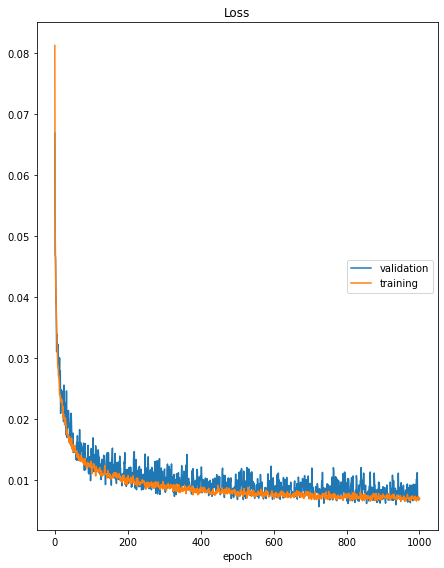

Loss
	validation       	 (min:    0.006, max:    0.067, cur:    0.007)
	training         	 (min:    0.007, max:    0.081, cur:    0.007)
Time elapsed: 113.36s.
Number of trainable model parameters: 31101, number of training samples: 929
Used batches of 50.

Time taken: 113.69557332992554s


In [9]:
start = time.time()

net, train_loss, val_loss = model.train_model(LLP=True,                        # Live loss plot, defulat: True
                                              checkpoint=True,                 # Must be True to continue training later
                                              checkpoint_path=checkpoint_path) # Savename for the trained model checkpoint

end = time.time()
print(f"Time taken: {end-start}s")

# Perform Forward Passes for each Dataset

In [10]:
samples_train, means_train, stds_train, y_train_np = model.run_sampling(x_train, y_train)
samples_test, means_test, stds_test, y_test_np = model.run_sampling(x_test, y_test)             
samples_val, means_val, stds_val, y_val_np = model.run_sampling(x_val, y_val)

***
***
# Post-Processing and Visualisation

## Count number of 'untrustworthy' predictions
This function checks how many of the true values in each dataset (test, train, val) fall outside the confidence interval.

It does *not* tell us how accurate the mean predictions are.

In [11]:
err_train = post.count_wrong_preds(samples_train, y_train_np, 1, "SD", False)
err_test = post.count_wrong_preds(samples_test, y_test_np, 1, "SD", False)
err_val = post.count_wrong_preds(samples_val, y_val_np, 1, "SD", False)

print(f"Untrustworthy in train:\t{np.sum(err_train)}\t(low: {err_train[0]}, high: {err_train[1]})")
print(f"Untrustworthy in test:\t{np.sum(err_test)}\t(low: {err_test[0]}, high: {err_test[1]})")
print(f"Untrustworthy in val:\t{np.sum(err_val)}\t(low: {err_val[0]}, high: {err_val[1]})")
print("----------------------")
print(f"Total untrustworthy:\t{np.sum(err_train)+np.sum(err_test)+np.sum(err_val)}")

Untrustworthy in train:	2	(low: 2, high: 0)
Untrustworthy in test:	523	(low: 469, high: 54)
Untrustworthy in val:	2	(low: 2, high: 0)
----------------------
Total untrustworthy:	527


## Plot the Uncertainty of Each Datapoint (Train, Test and Val)

The plot below shows us intuitively what the accuracy and uncertainty of predictions in each dataset is. From this, it's clear to see that the prediction accuracy is high in the training and validation set, and both the accuracy and certainty in the test set are low as expected. 

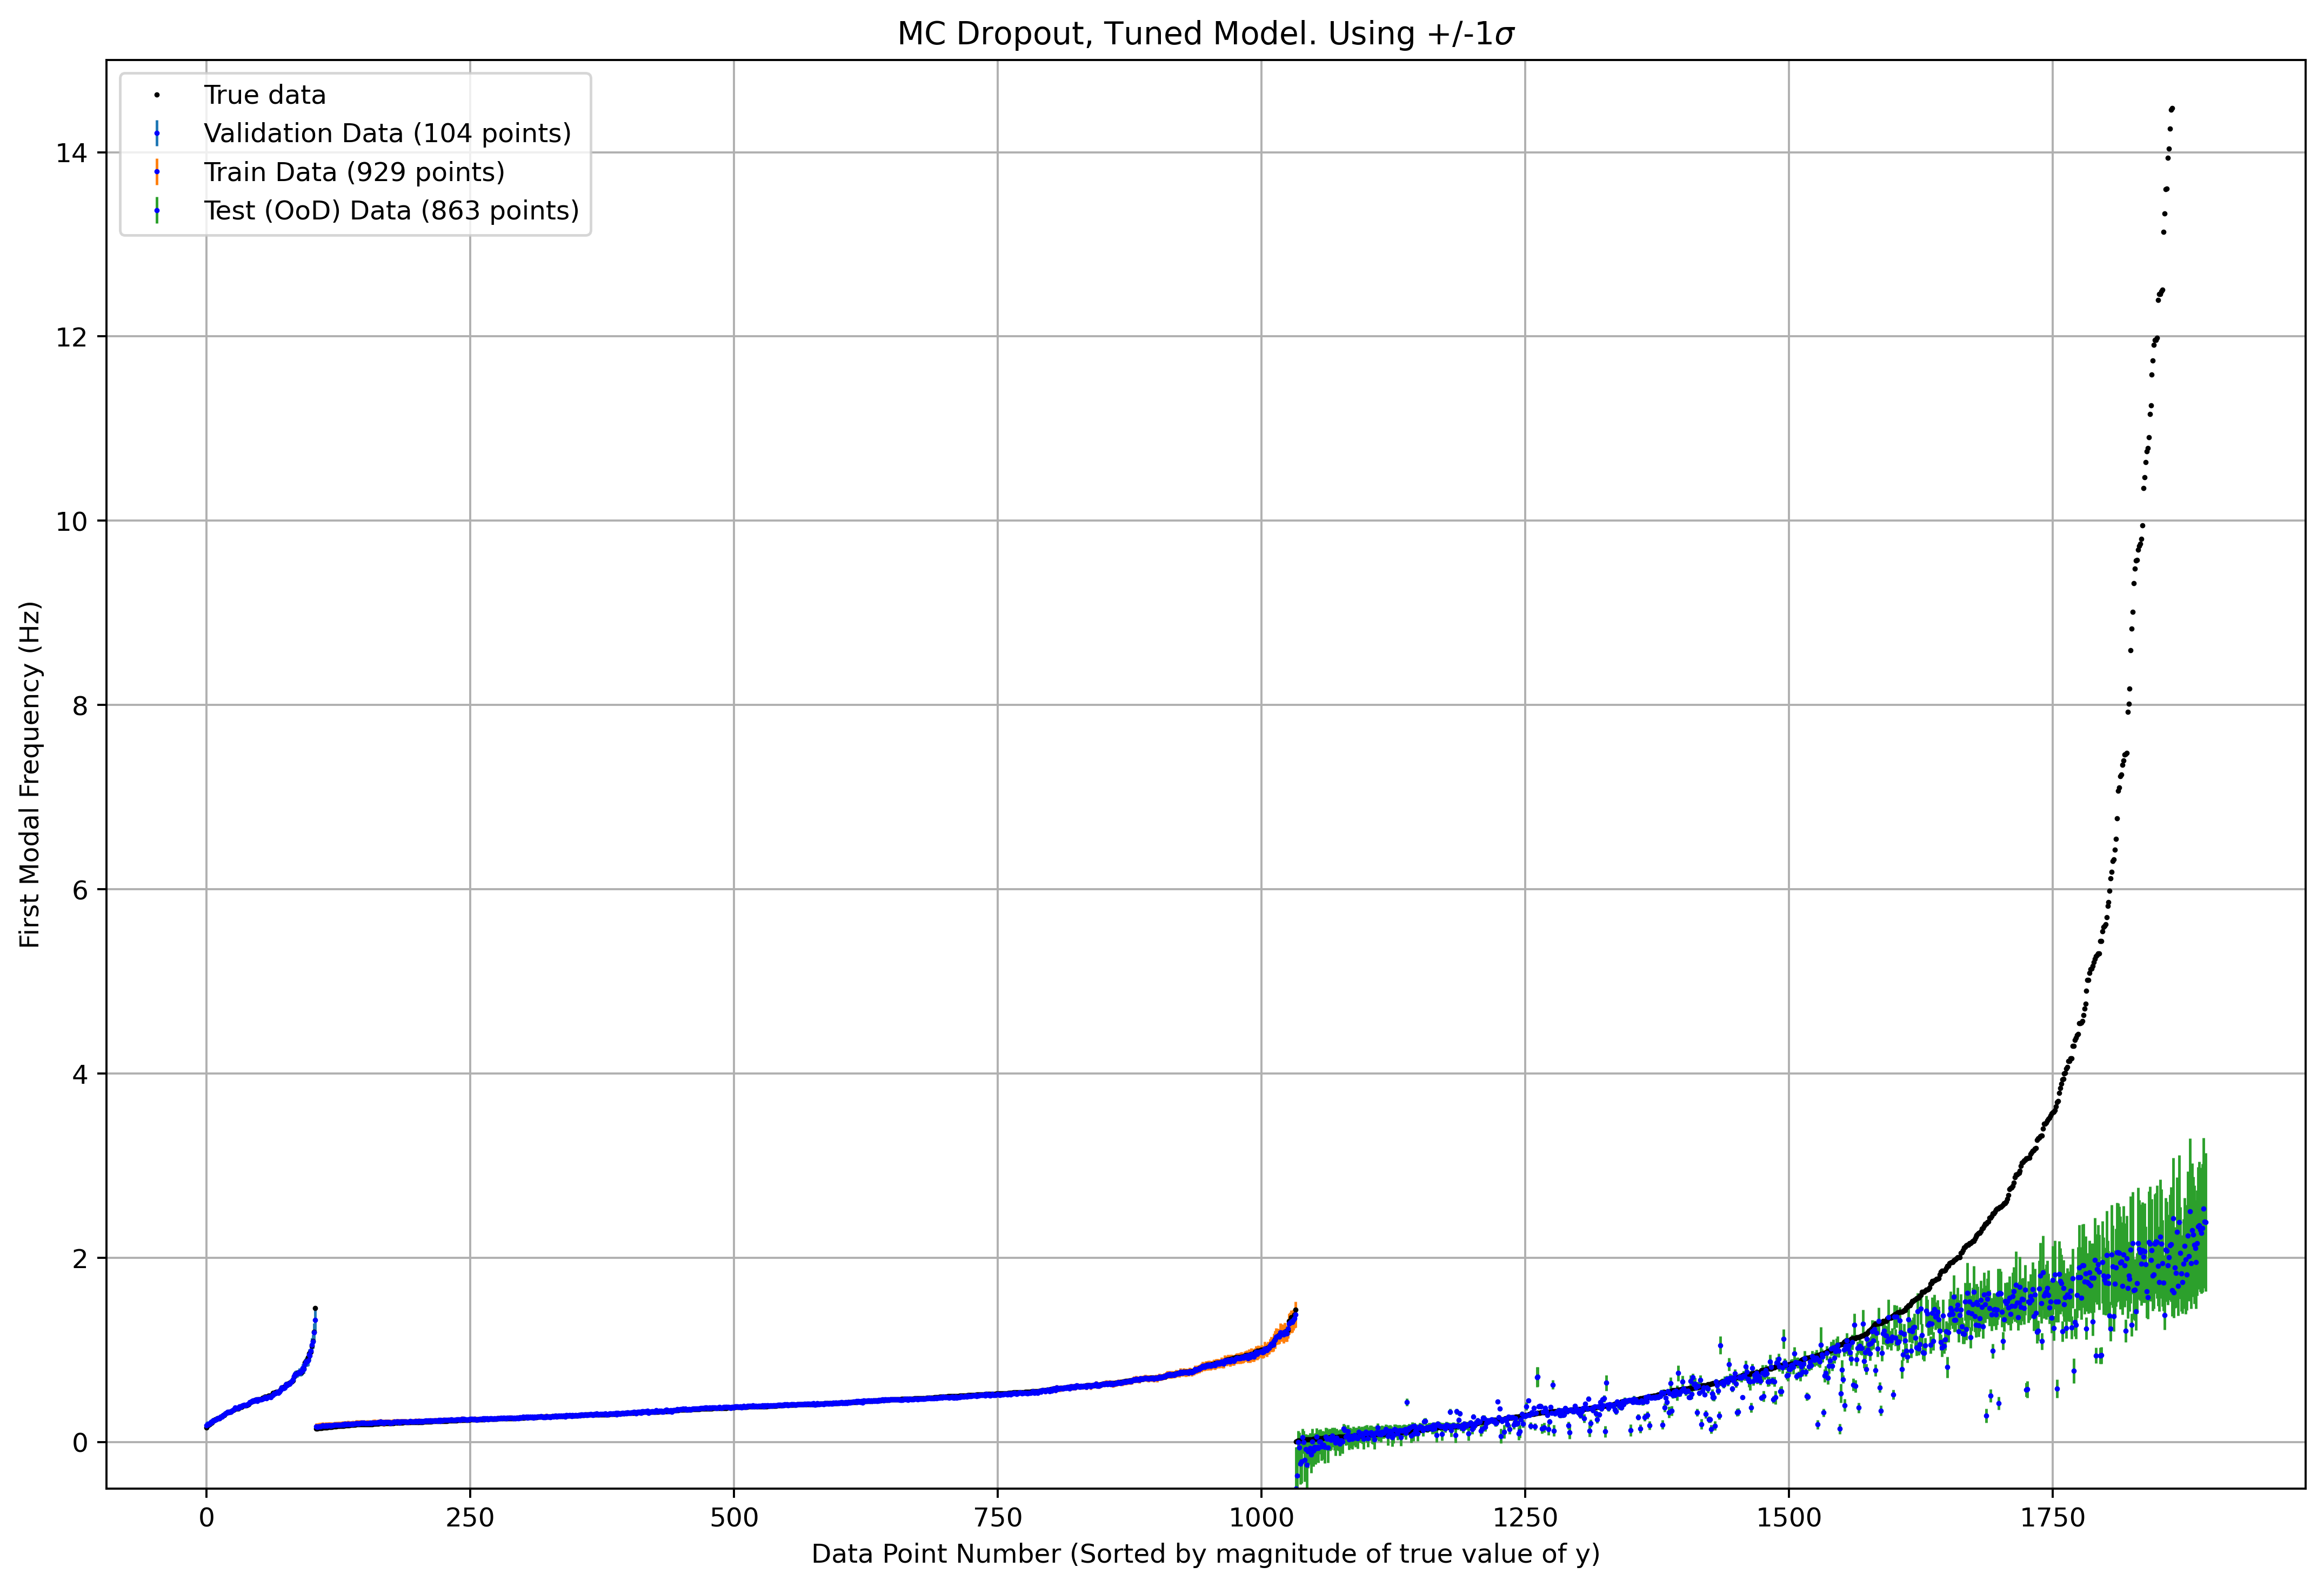

In [12]:
uncert_plot = post.result_plots(all_samples = [samples_val, samples_train, samples_test],
             labels = ["Validation", "Train", "Test (OoD)"],
             output_labels = ["freq1", "freq2", "freq3"],
             all_true = [y_val_np, y_train_np, y_test_np],
             output_num=0,
             #true_inds = [val_indices, train_indices, test_indices],
             interval = 1,
             method="SD",
             component_name = parameters["component"],
             sort=True,
             sortby="0",
             bar_method="bars",
             title="MC Dropout, Tuned Model",
             ylabel="First Modal Frequency (Hz)",
              figsize=(15,10),
             ylim=(-0.5,15),
                               dpi=200)

### Ridgeline Plot

This visualises the distribution for each point prediction made. Every eighth datapoint is omitted for clarity of the plot.

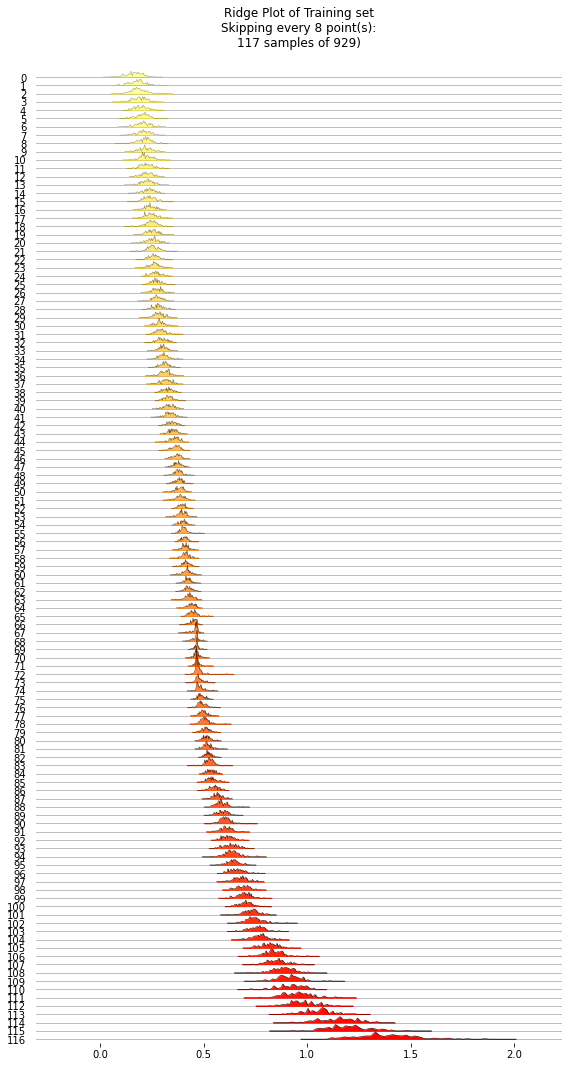

In [13]:
import joypy
from matplotlib import cm

%matplotlib inline
means_train2, samples_train2, stds_train2 = post.sort_data([means_train, samples_train, stds_train],sortby=0) 
skip_every = 8
data = pd.DataFrame(samples_train2.squeeze()[:,::skip_every])

fig, axes = joypy.joyplot(pd.DataFrame(samples_train2.squeeze()[:,::skip_every]),
                          range_style='own', # Limits each subplot to the area where it's non-zero
                          #ylabels=False,   # Also turns off horz grid lines if False
                          #xlabels=True,
                          overlap=0.5,        
                          grid='y',        # 'y': Horz grid lines, True: horz and vert
                          linewidth=0.5,     # Outlines
                          #labels = labels,   # Which y labels to plot (corresponding to horz lines). Doesn't work for some reason
                          kind='counts',   # Plotting raw counts rather than estimated density
                          #legend=True,   
                          figsize=(8,15),
                          bins=50, 
                          fade=True,       # subplots get progressively higher alpha values 
                          title=f"Ridge Plot of Training set\nSkipping every {skip_every} point(s):\n{data.shape[1]} samples of {len(means_train[0])})",
                          colormap=cm.autumn_r);

## Show the Distribution of Errors and Uncertainties in each Dataset
### Using Histograms

These plots make a range of summaries about the dataset and predictions.

In row major ordering:

 - Plot 1: The error between each prediction sample and the true value. This outlines the accuracy of the predictions, and the spread of the samples.  
 - Plot 2: Very similar to Plot 1, except looking at the mean of all samples drawn for each datapoint. This outlines the accuracy of the predictions. 
 - Plot 3: Shows the absolute width of the confidence interval of every data point in each set. This outlines the uncertainty of the predictions.  
 - Plot 4: Shows the distribution of the predicted values in each dataset. This outlines the performance of the model as well as describing the dataset.
 - Plot 5: If a confidence interval does not capture the true y value, then how far outside the confidence interval is the y value?

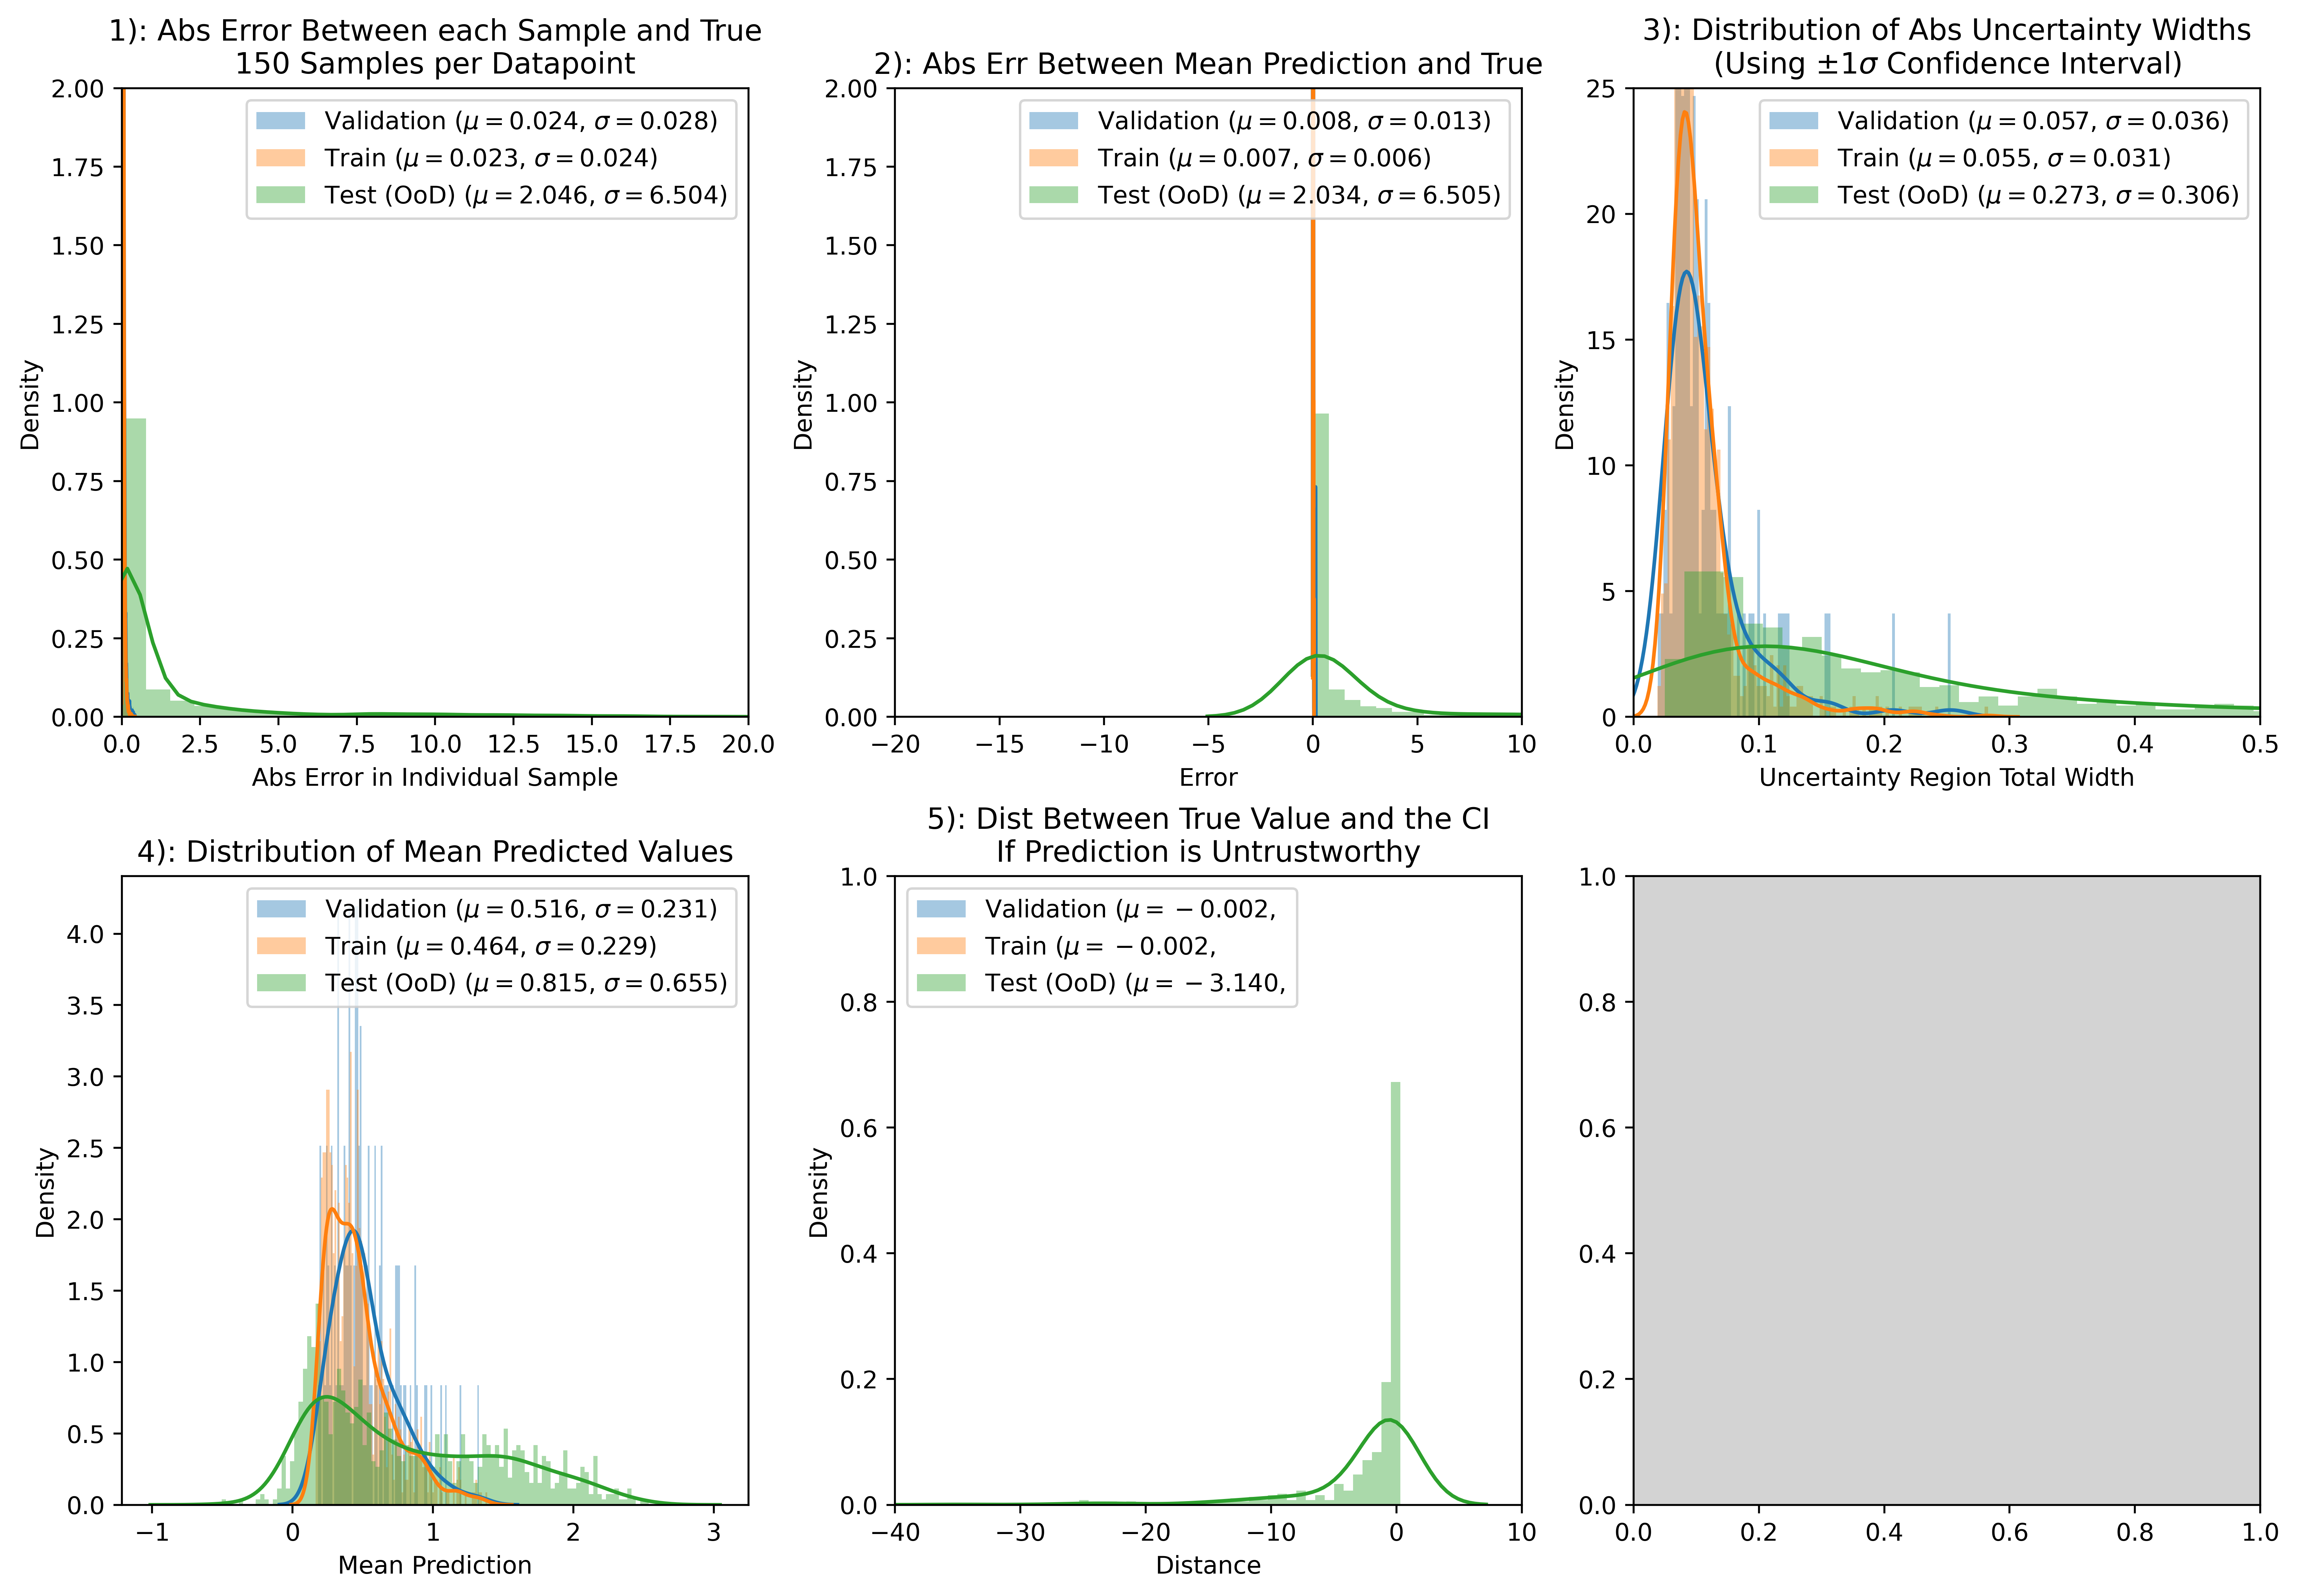

In [14]:
%matplotlib inline
samples = [samples_val, samples_train, samples_test]
true = [y_val_np, y_train_np, y_test_np]
labels=["Validation", "Train", "Test (OoD)"]
histograms1, statistics1 = post.histogram_stats(samples,
                                                true,
                                                labels,
                                                method="SD",
                                                interval=1,
                                                dp=.3,
                                                bins=100,
                                                figsize=(13,9),
                                                plot_1_ylim=(0,2),
                                                plot_1_xlim=(0,20),
                                                plot_2_ylim=(0,2),
                                                plot_3_ylim=(0,25),
                                                plot_3_xlim=(0,0.5),
                                                plot_2_xlim=(-20,10),
                                                plot_5_ylim=(0,1),
                                                plot_5_xlim=(-40,10))
                                                

# Save the image to weights and biases
if wandb_mode: wandb.log({"Histograms_output0":wandb.Image(histograms1)})
if wandb_mode: wandb.log({"Data_output0":statistics1})
    
    
# Print the individual figures shown in the histograms
# import json
# print(json.dumps(statistics1, indent=6, default=str))

### Using Prinicpal Component Analysis in 3D

This intuitively shows both the distribution of test/train/validation data, as well as the uncertainty of the predictions in each of those sets. 

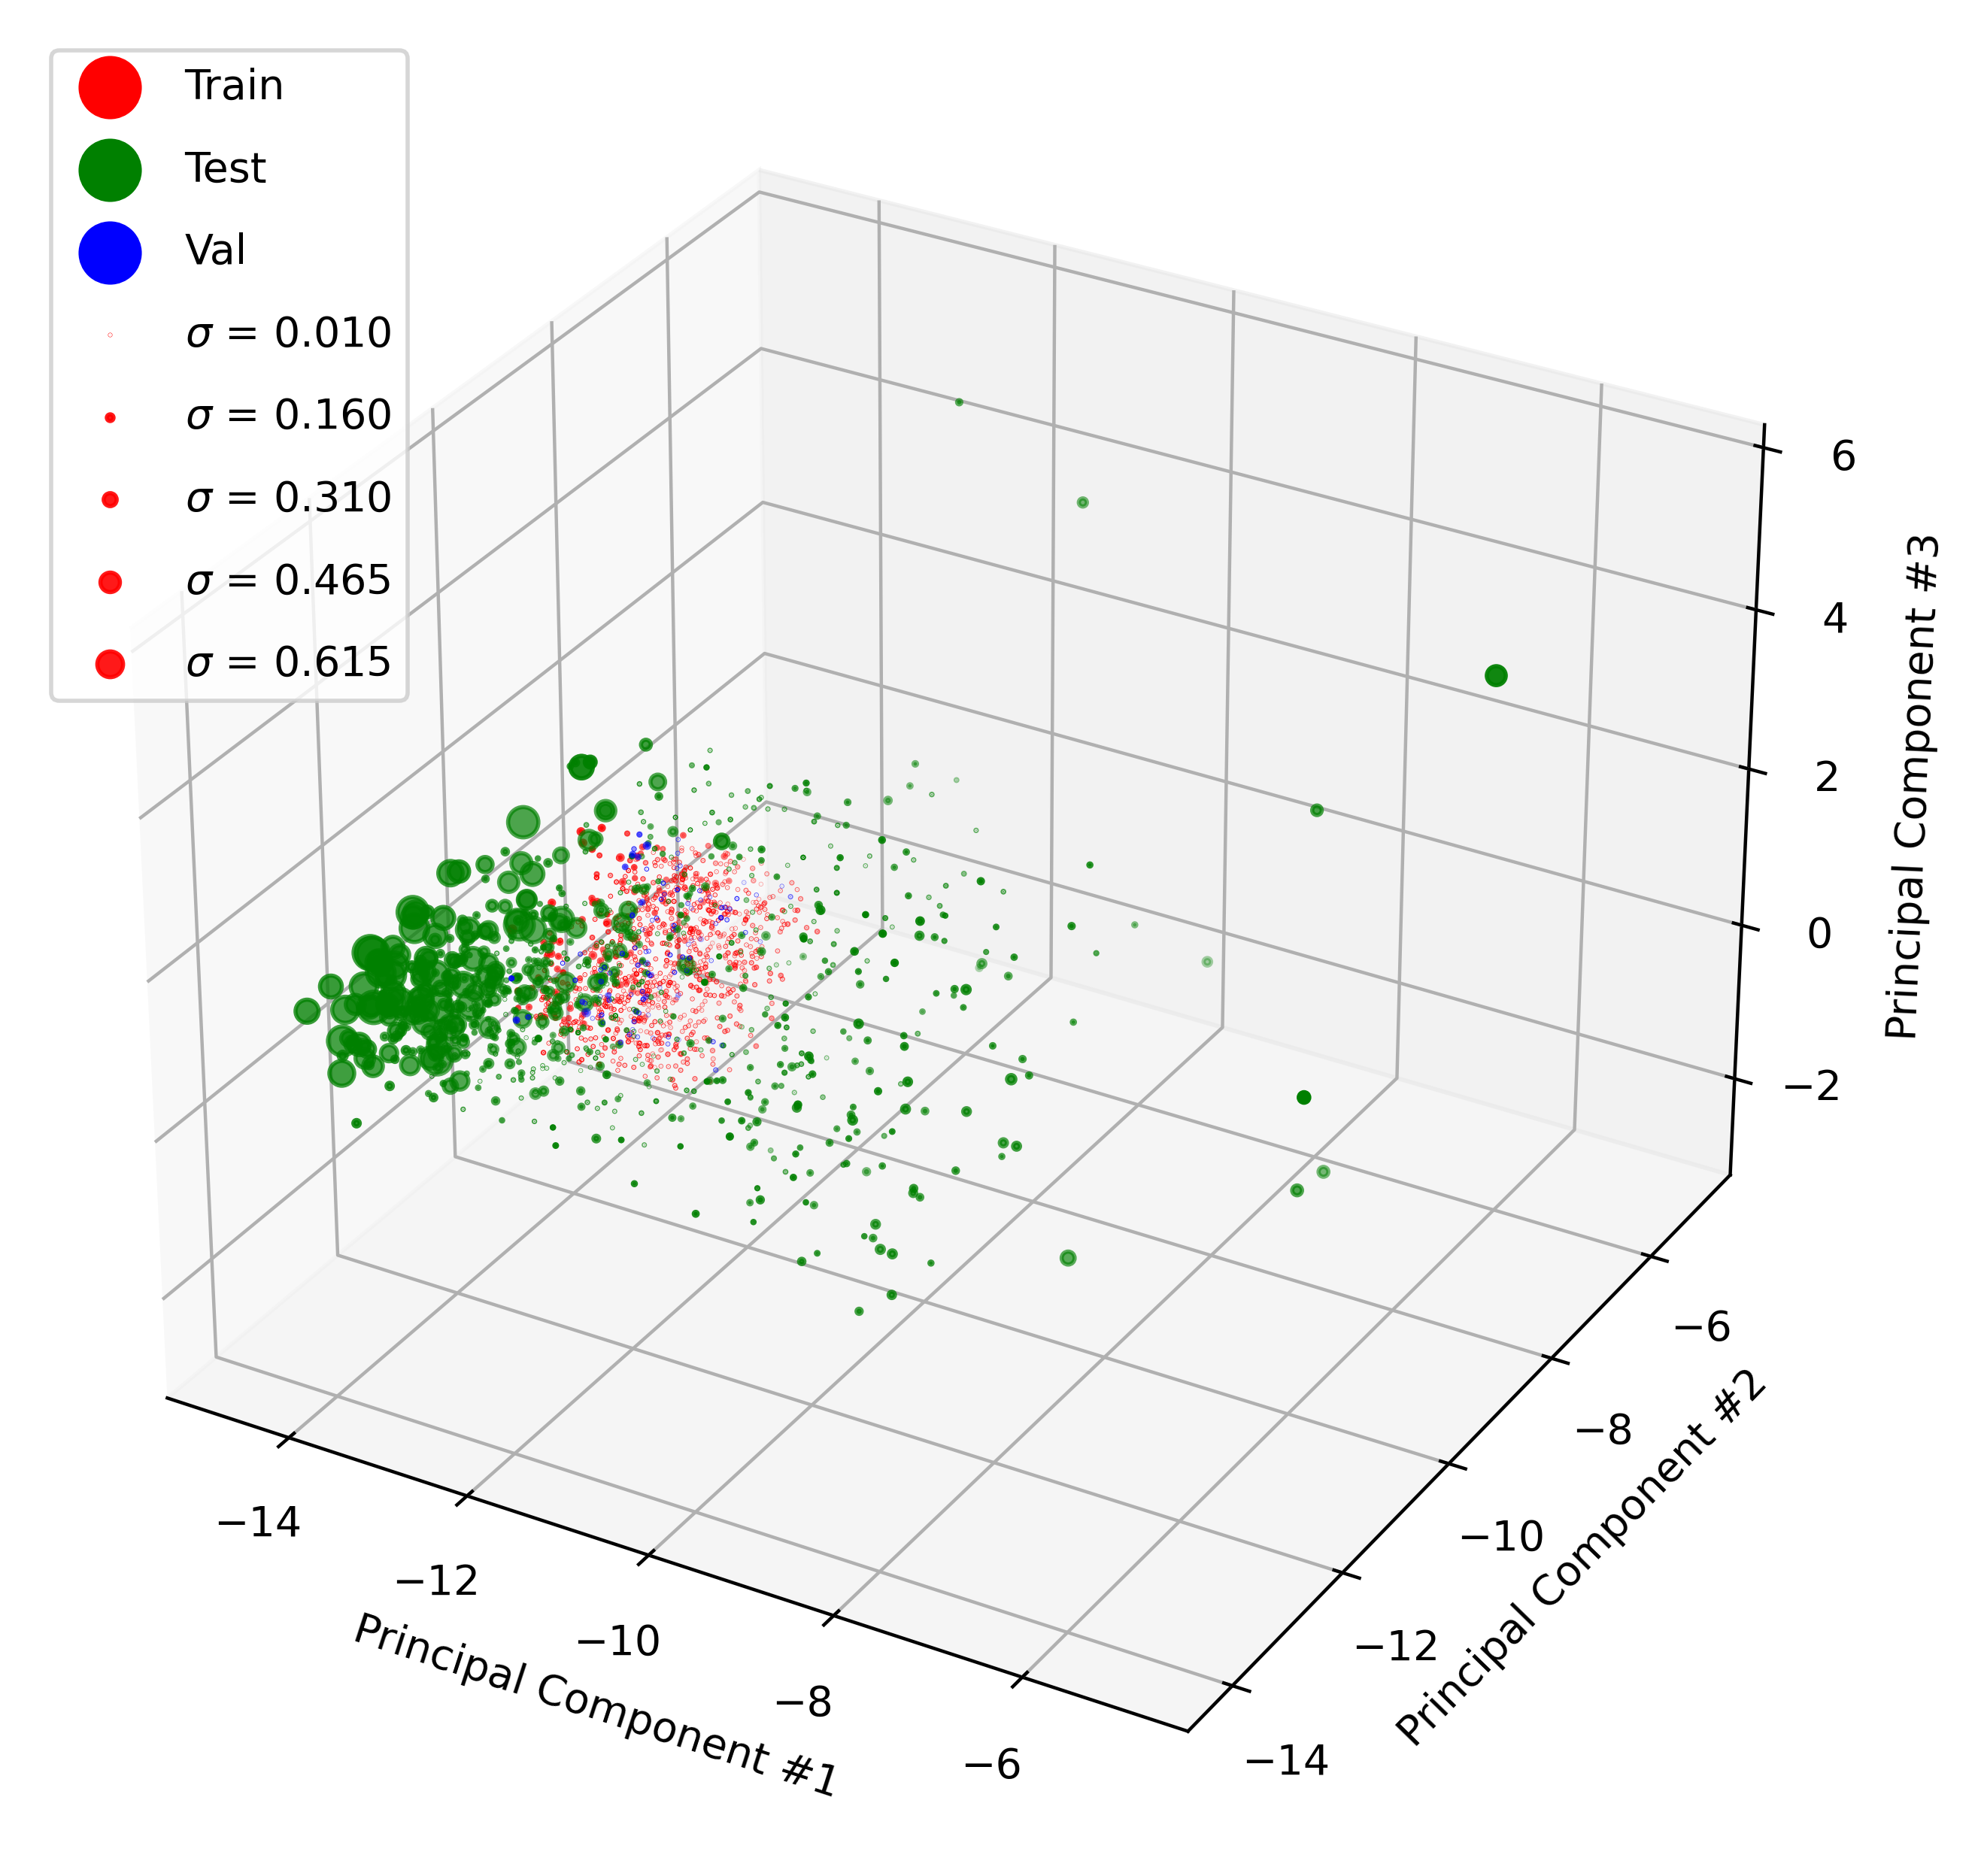

<Axes3DSubplot:xlabel='Principal Component #1', ylabel='Principal Component #2'>

In [15]:
#%matplotlib notebook
x_train_PCA = post.PCA_transformdata(x_train, components=components)
x_test_PCA = post.PCA_transformdata(x_test, components=components)
x_val_PCA = post.PCA_transformdata(x_val, components=components)

post.PCA_plot([x_train_PCA, x_test_PCA, x_val_PCA], 
              [stds_train, stds_test, stds_val],
              labels=["Train", "Test", "Val"],
              output_num= 0,
              figsize=(8,8),
              scalingfactor=10,
              scalingpower=2,
              produce_animation=False,
              legend_num=5,
              legend_HDI=0.99,
              dpi = 400)

# Making Predictions on Unseen Data

## Forward Passes of a Single Datapoint

Here, we can make a single prediction on an arbitrary datapoint. The function returns the array of samples, a mean and a standard deviation from that mean. 

In [16]:
num_samples = 150
x_value = np.array([5, 5, 5, 10, 10, 10])

s, m, sd = model.make_prediction(x_value = x_value,
                          model = model,
                          data_mean = data_mean,
                          data_std = data_std,
                          verbose=False,            # Optional, default=False
                          plots=False,              # Optional, default=False
                          num_samples=num_samples)  # Optional, default = 100

print(f"Using X = {x_value}, modal frequency = {m.item():.3f} Hz, +/- {sd.item():.3f} Hz (+/-{100*sd.item()/m.item():.2f}%)")

Using X = [ 5  5  5 10 10 10], modal frequency = 0.261 Hz, +/- 0.023 Hz (+/-8.98%)


## Check Uncertainties of in-domain vs OOD Points

Here, we can run a range of predictions over a given domain and visualise the resulting uncertainty, both in absolute terms and in relative uncertainty ($\sigma$/$\mu$).

 - *params* is laid out like: `[num\_x, num\_y, num\_z, dim\_x, dim\_y, dim\_z]`.
 - To plot a param as constant, set it to e.g. `[5]` for 5.
 - To plot a param as a range, set it to e.g. `[1, 50, 10]` to do `np.linspace(1, 50, 10)`.
 - Can only set 3 as ranges at a time! Axes automatically get renamed to accomodate the change

Note that the complexity scales with the cube of the number of samples!

In [17]:

params = [[1, 20, 10], [1, 20, 10], [1, 50, 10], [5], [5], [5]]

# all_domain: Draws the cube that indicates the training domain. Same format as above.
all_domain = [[3, 10], [3, 10], [3, 10], [5, 10], [5, 10], [5, 10]]

num_samples=20               # How many forward passes to do per datapoint to get the posterior distribution
figsize = (10, 10)           # Figure size

means_pred, stds_pred, percent_uncert, xxx, yyy, zzz, labels, ranges, consts = post.generate_3d_samples(model,
                             params=params,
                             num_samples=num_samples)     # Optional, defualt=20

Variable parameter / axis labels = ['num_x', 'num_y', 'num_z']
Cycling through 10*10*10 = 1000 options..


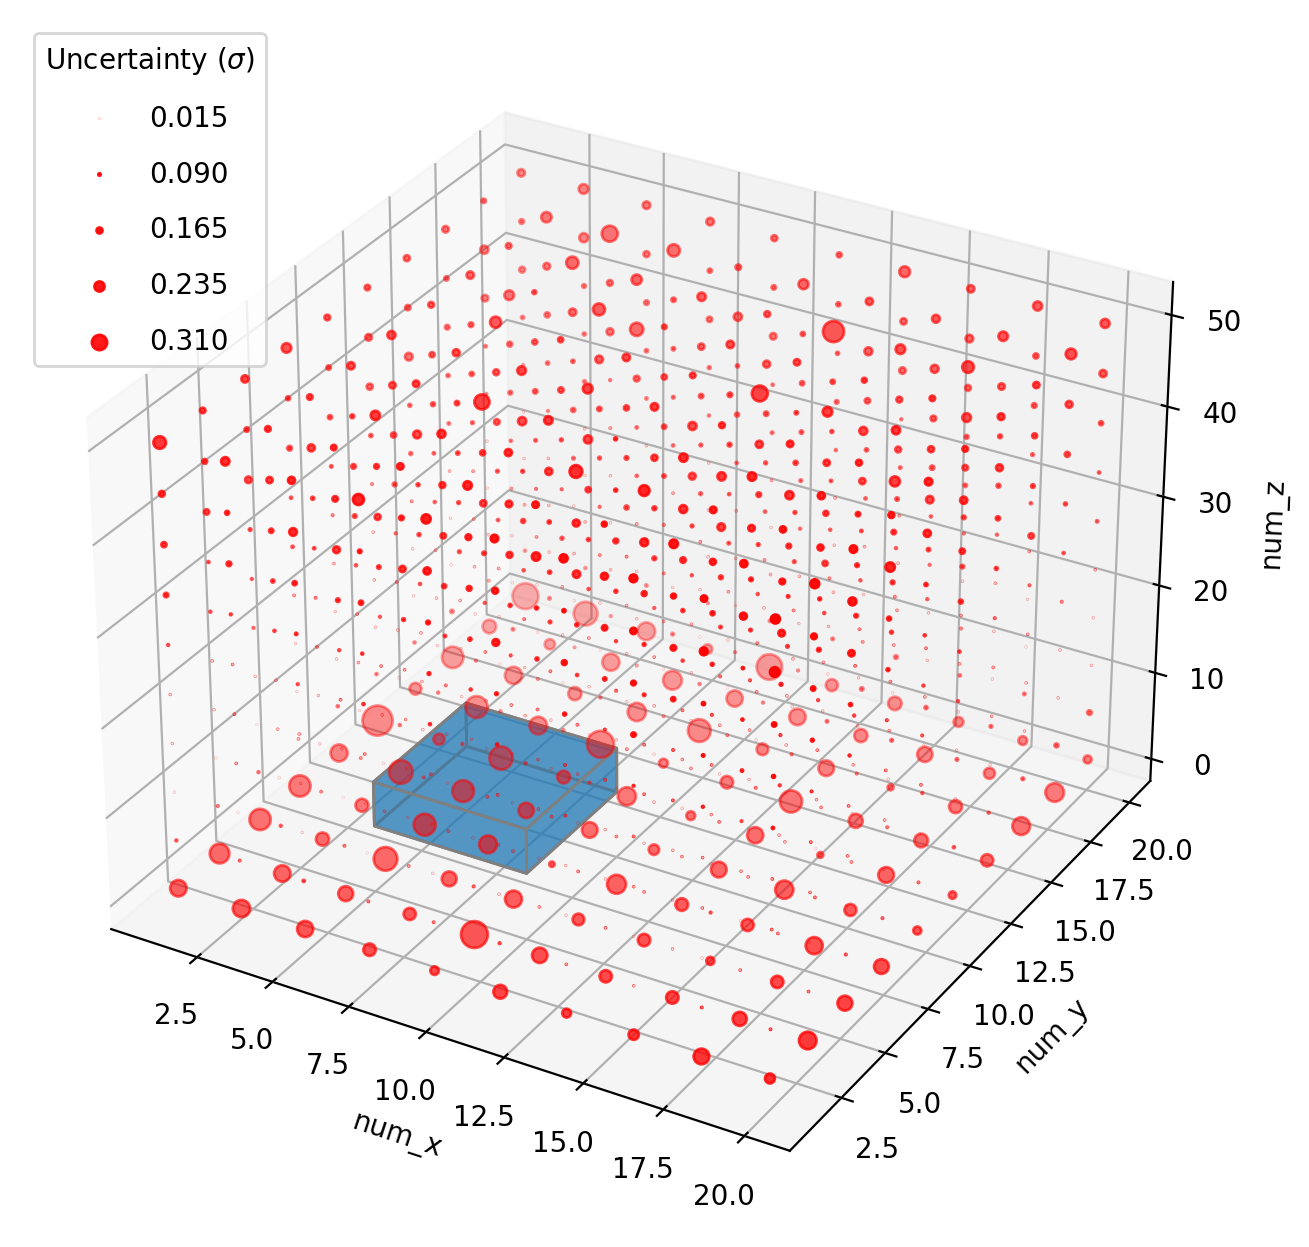

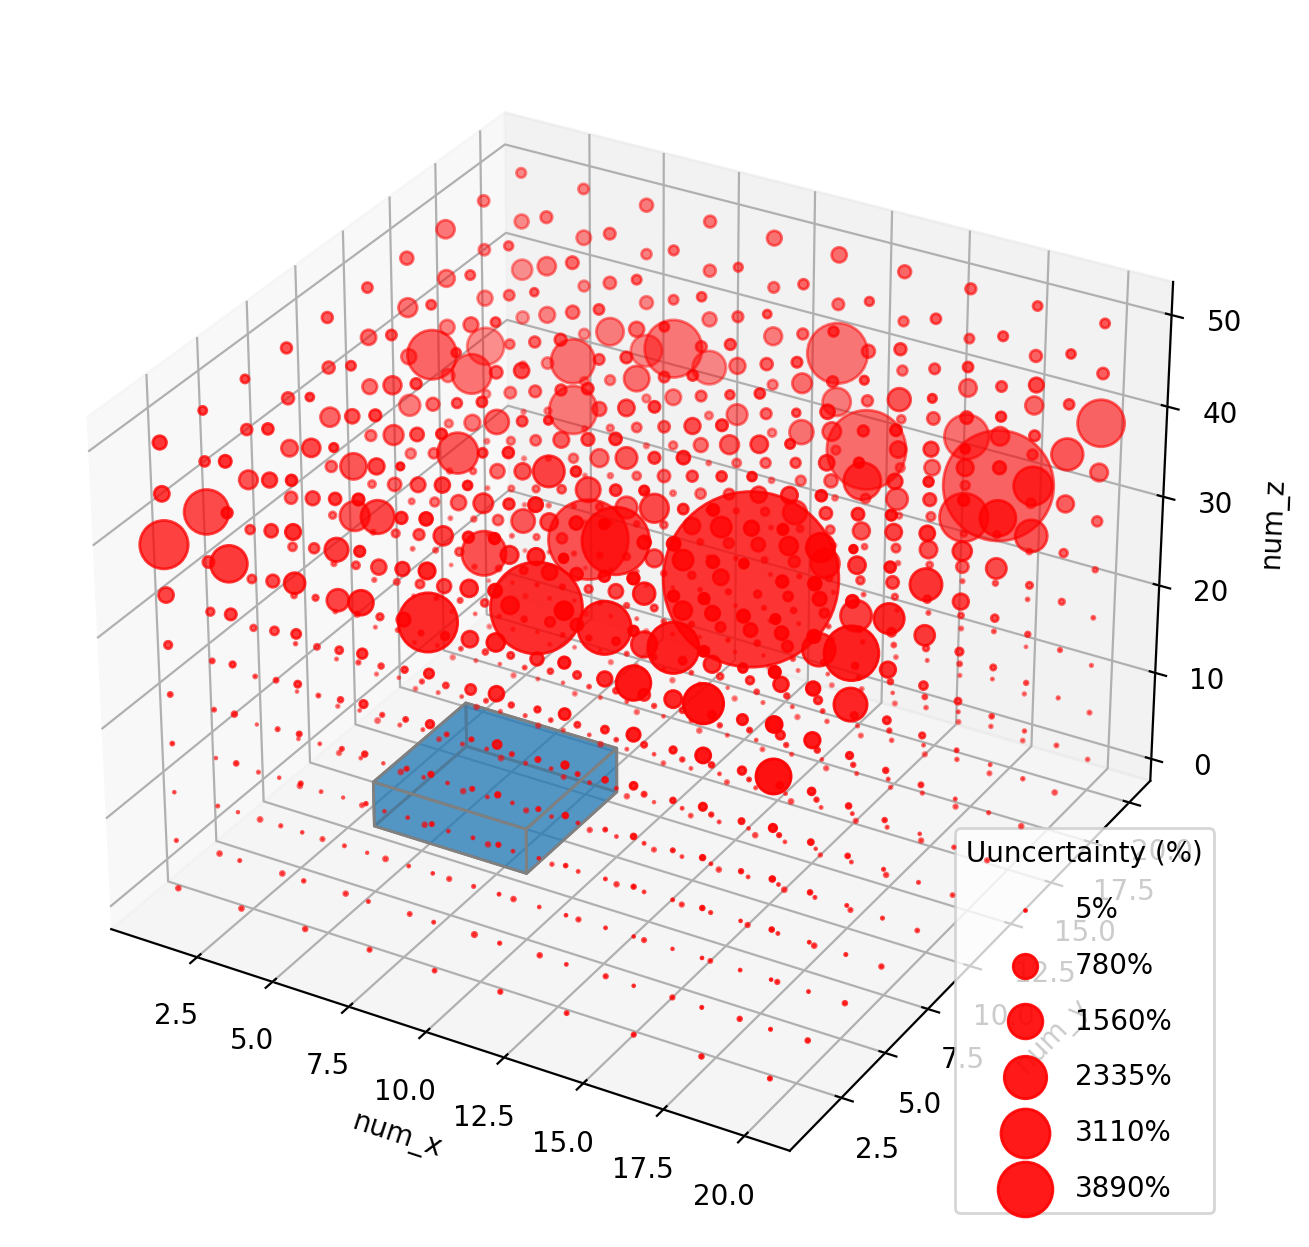

In [18]:
#%matplotlib inline  
post.generate_3d_plot(means_pred,                  # Mean prediction values of every point in cube
                 stds_pred,                   # Std of every point in cube
                 percent_uncert,              # Percent uncertainty every point in cube
                 xxx, yyy, zzz,               # Meshgrid for x, y and z
                 labels=labels,               # Labels for x, y and z axes. E.g. ["dim_x", "dim_y", "dim_z"]
                 ranges=ranges,               # Which parameter numbers are set as ranges
                 consts=consts,               # Which parameter numbers are constant
                 all_domain = all_domain,     # Draw the cube that represents the training domain
                 scale=False,                  # Scale all the axes to maintain relative size 
                 mode="absolute",             # "absolute": SD values. "relative": 100*(SD/mu). Default="absolute"
                 produce_animation=False,     # Default=False
                 animation_name="_.mp4",      # Default="./animation.mp4"
                 figsize=(8,8),             # Optional, default=(15,15)
                 scalingpower=3,              # Raise SD to this power when using "absolute" to scale size. Optional, default=3
                 scalingscalar=10)            # Multiply SD by this before raising to power. Optional, default=10

post.generate_3d_plot(means_pred,                  # Mean prediction values of every point in cube
                 stds_pred,                   # Std of every point in cube
                 percent_uncert,              # Percent uncertainty every point in cube
                 xxx, yyy, zzz,               # Meshgrid for x, y and z
                 ranges=ranges,               # Which parameter numbers are set as ranges
                 consts=consts,               # Which parameter numbers are constant
                 all_domain = all_domain,     # Draw the cube that represents the training domain
                 labels=labels,               # Labels for x, y and z axes. E.g. ["dim_x", "dim_y", "dim_z"]
                 scale=False,                 # Scale all the axes to maintain relative size 
                 mode="relative",             # "absolute": SD values. "relative": 100*(SD/mu). Default="absolute"
                 produce_animation=False,     # Default=False
                 animation_name="_.mp4",      # Default="./animation.mp4"
                 figsize=(8,8),             # Optional, default=(15,15)
                 scalingpower=2,              # Raise SD to this power when using "absolute" to scale size. Optional, default=3
                 scalingscalar=0.1,           # Multiply SD by this before raising to power. Optional, default=10
                 limit=4000,                  # What size to limit the point to (optional, default: 4000). Only for "relative" mode             
                 legend_num=6,                # How many legend entries to show
                 legend_HDI=0.99)             # HDI for setting upper and lower bound of legend

# Finish up Run in Weights & Biases

In [19]:
if wandb_mode: wandb.finish()

# Save Model State

In [20]:
#torch.save(model, "../trained_models/for_prediction/MCDropout")

# Train the Model with More Data Available

## Split the dataset again

OOD lower:	488
OOD upper:	188
Train:		1233
Test:		607
Val:		138
Unused:		0
Total:		1978 (of 1978)


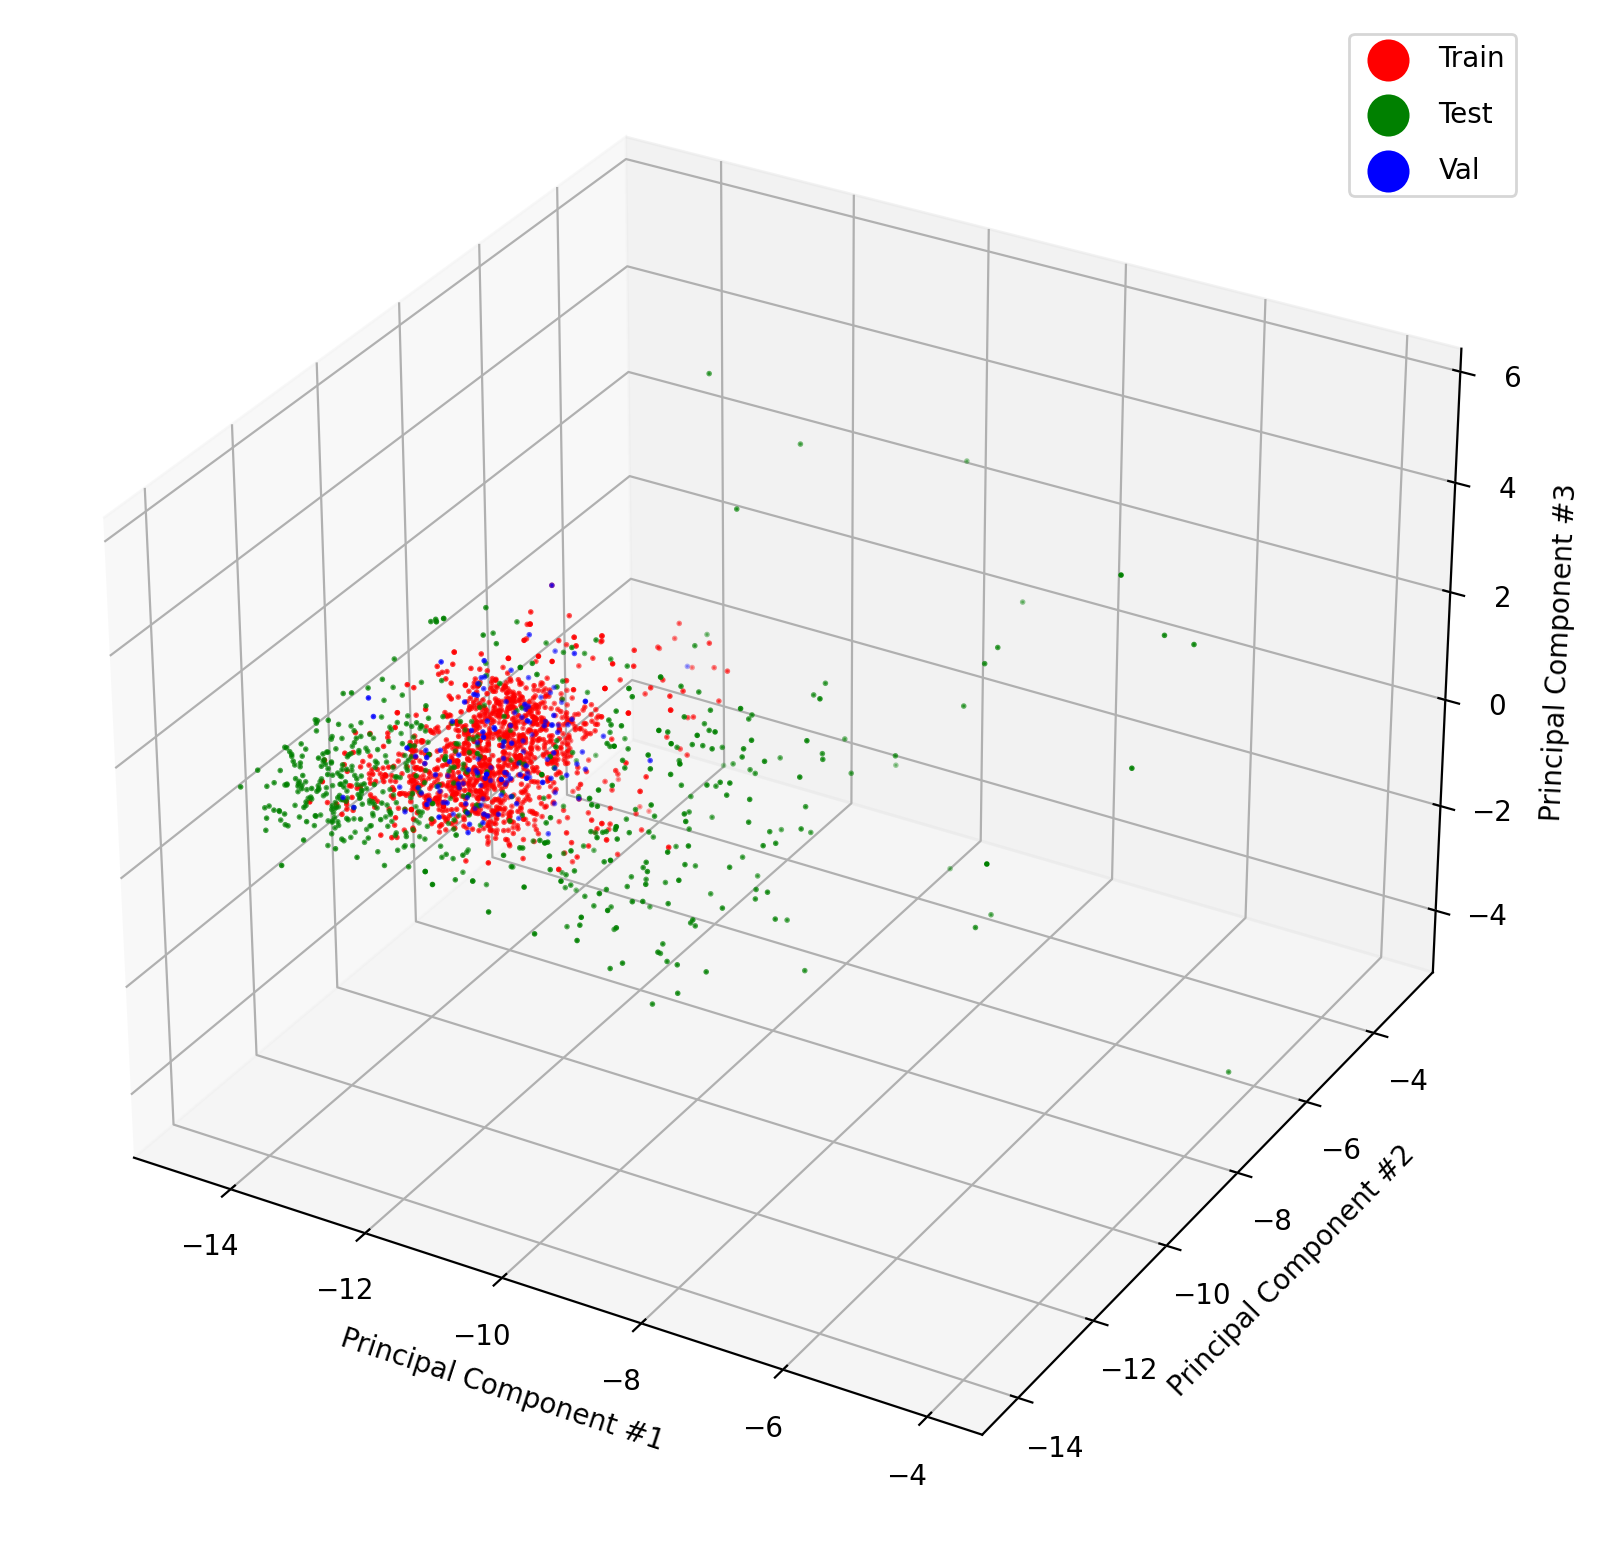

In [21]:
ood_lims_in2 = [[0., 2.], [0., 2.], [0., 2.], [0., 2.], [0., 2.], [0., 2.]]
train_lims_all2 = [[2., 15], [2., 15], [2., 15], [2., 15], [2., 15], [2., 15]]
ood_lims_out2 = [[15, 30], [15, 30], [15, 50], [15, 25], [15, 25], [15, 25]]

TRAIN2, VAL2, TEST2 = pre.split_by_bounds(df=df_orig.copy(),
                                 x_cols=x_cols,
                                 y_cols=y_cols,
                                 train_lims_all=train_lims_all2,
                                 ood_lims_in=ood_lims_in2,
                                 ood_lims_out=ood_lims_out2,
                                 data_mean=data_mean, 
                                 data_std=data_std, 
                                 PCA_components=components,
                                 val_split=0.1,
                                 verbose=True,
                                 plots=True,
                                 figsize=(10,10))
                                      #save_image=False, savename="../reports/final_report_images/splitting_data/manual_bounds.eps", saveformat="eps")

x_train2, y_train2, train_data2, train_indices2 = TRAIN2
x_val2, y_val2, val_data2, val_indices2 = VAL2
x_test2, y_test2, test_data2, test_indices2 = TEST2

y_train_unnorm = pre.unnormalise(y_train2,data_mean[y_cols].values,data_std[y_cols].values)
y_val_unnorm = pre.unnormalise(y_val2,data_mean[y_cols].values,data_std[y_cols].values)
y_test_unnorm = pre.unnormalise(y_test2,data_mean[y_cols].values,data_std[y_cols].values)


## Load the Previous Model Progress and Continue Training

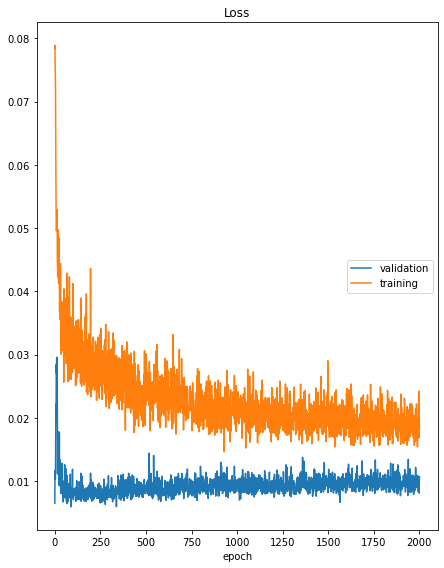

Loss
	validation       	 (min:    0.006, max:    0.030, cur:    0.011)
	training         	 (min:    0.015, max:    0.079, cur:    0.018)
Time elapsed: 79.13s.
Number of trainable model parameters: 31101, number of training samples: 1233
Used batches of 1233.

Ran epoch 1000 to 3000


In [22]:
checkpoint = torch.load(checkpoint_path)
model.net.load_state_dict(checkpoint['model'])
model.optimiser.load_state_dict(checkpoint['optimiser'])

start_epoch2 = checkpoint['epoch']
epochs2 = 2000 
batch_size2 = len(train_data2)


model.wandb_mode = False  # We've already done the training and finished up wandb, so disable this

net, train_loss, val_loss = model.retrain_model(train_data2, batch_size2, epochs2, save_checkpoint=True, checkpoint_path=checkpoint_path)

print(f"Ran epoch {start_epoch2} to {start_epoch2 + epochs2}")

In [23]:
samples_train2, means_train2, stds_train2, y_train_np2 = model.run_sampling(x_train, y_train)
samples_test2, means_test2, stds_test2, y_test_np2 = model.run_sampling(x_test, y_test)             
samples_val2, means_val2, stds_val2, y_val_np2 = model.run_sampling(x_val, y_val)

In [24]:
err_train2 = post.count_wrong_preds(samples_train2, y_train_np2, 1, "SD")
err_test2 = post.count_wrong_preds(samples_test2, y_test_np2, 1, "SD")
err_val2 = post.count_wrong_preds(samples_val2, y_val_np2, 1, "SD")

print(f"Train error:\t{np.sum(err_train2)}\tPREVIOUS:\t{np.sum(err_train)}")
print(f"Test error:\t{np.sum(err_test2)}\tPREVIOUS:\t{np.sum(err_test)}")
print(f"Val error:\t{np.sum(err_val2)}\tPREVIOUS:\t{np.sum(err_val)}")
print("----------------------")
print(f"Total error:\t{np.sum(err_train2)+np.sum(err_test2)+np.sum(err_val)}")

Train error:	0	PREVIOUS:	2
Test error:	293	PREVIOUS:	523
Val error:	0	PREVIOUS:	2
----------------------
Total error:	295


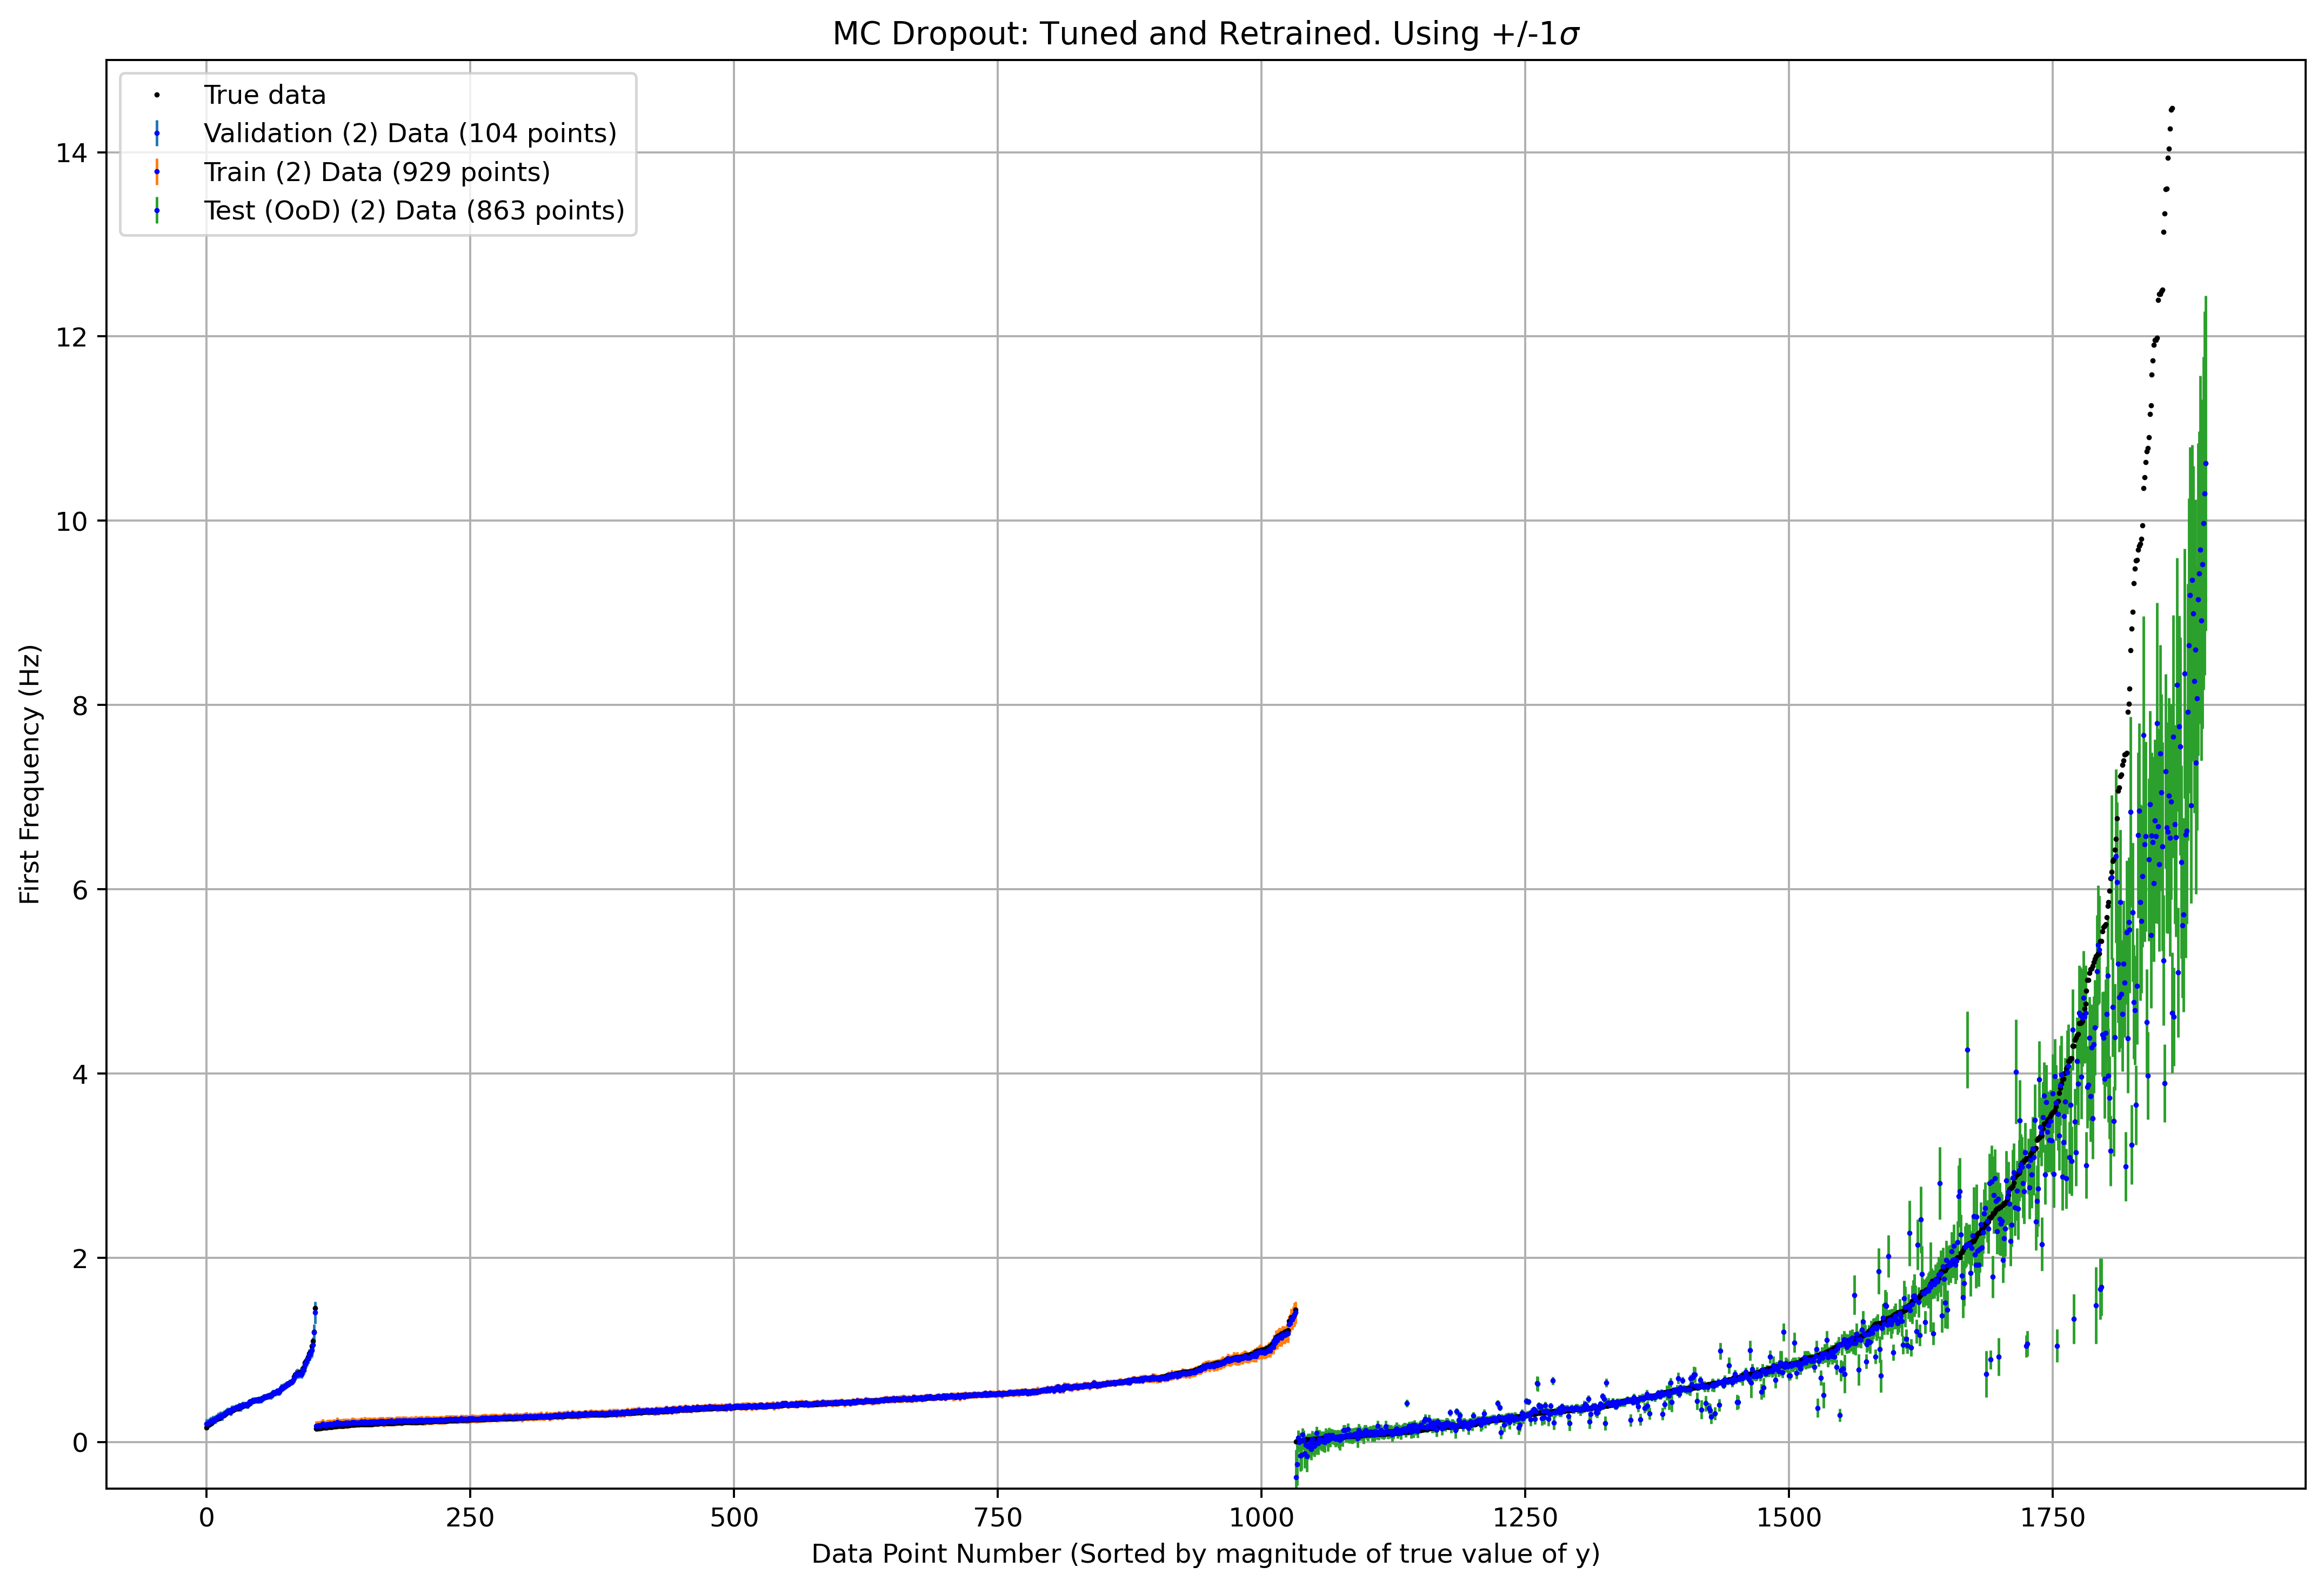

In [25]:
uncert_plot = post.result_plots(all_samples = [samples_val2, samples_train2, samples_test2],
             labels = ["Validation (2)", "Train (2)", "Test (OoD) (2)"],
             output_labels = ["freq1", "freq2", "freq3"],
             all_true = [y_val_np2, y_train_np2, y_test_np2],
             output_num=0,
             #true_inds = [val_indices, train_indices, test_indices],
             interval = 1,
             method="SD",
             component_name = parameters["component"],
             sort=True,
             sortby="0",
             bar_method="bars",
             title="MC Dropout: Tuned and Retrained",
             ylabel="First Frequency (Hz)",
              figsize=(15,10),
             ylim=(-0.5,15),
                               dpi=200)

C:\Users\aolux\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aolux\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\aolux\anaconda3\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\aolux\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\aolux\anaconda3\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\aolux\anaconda3\lib\site-packages\seaborn\distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, =

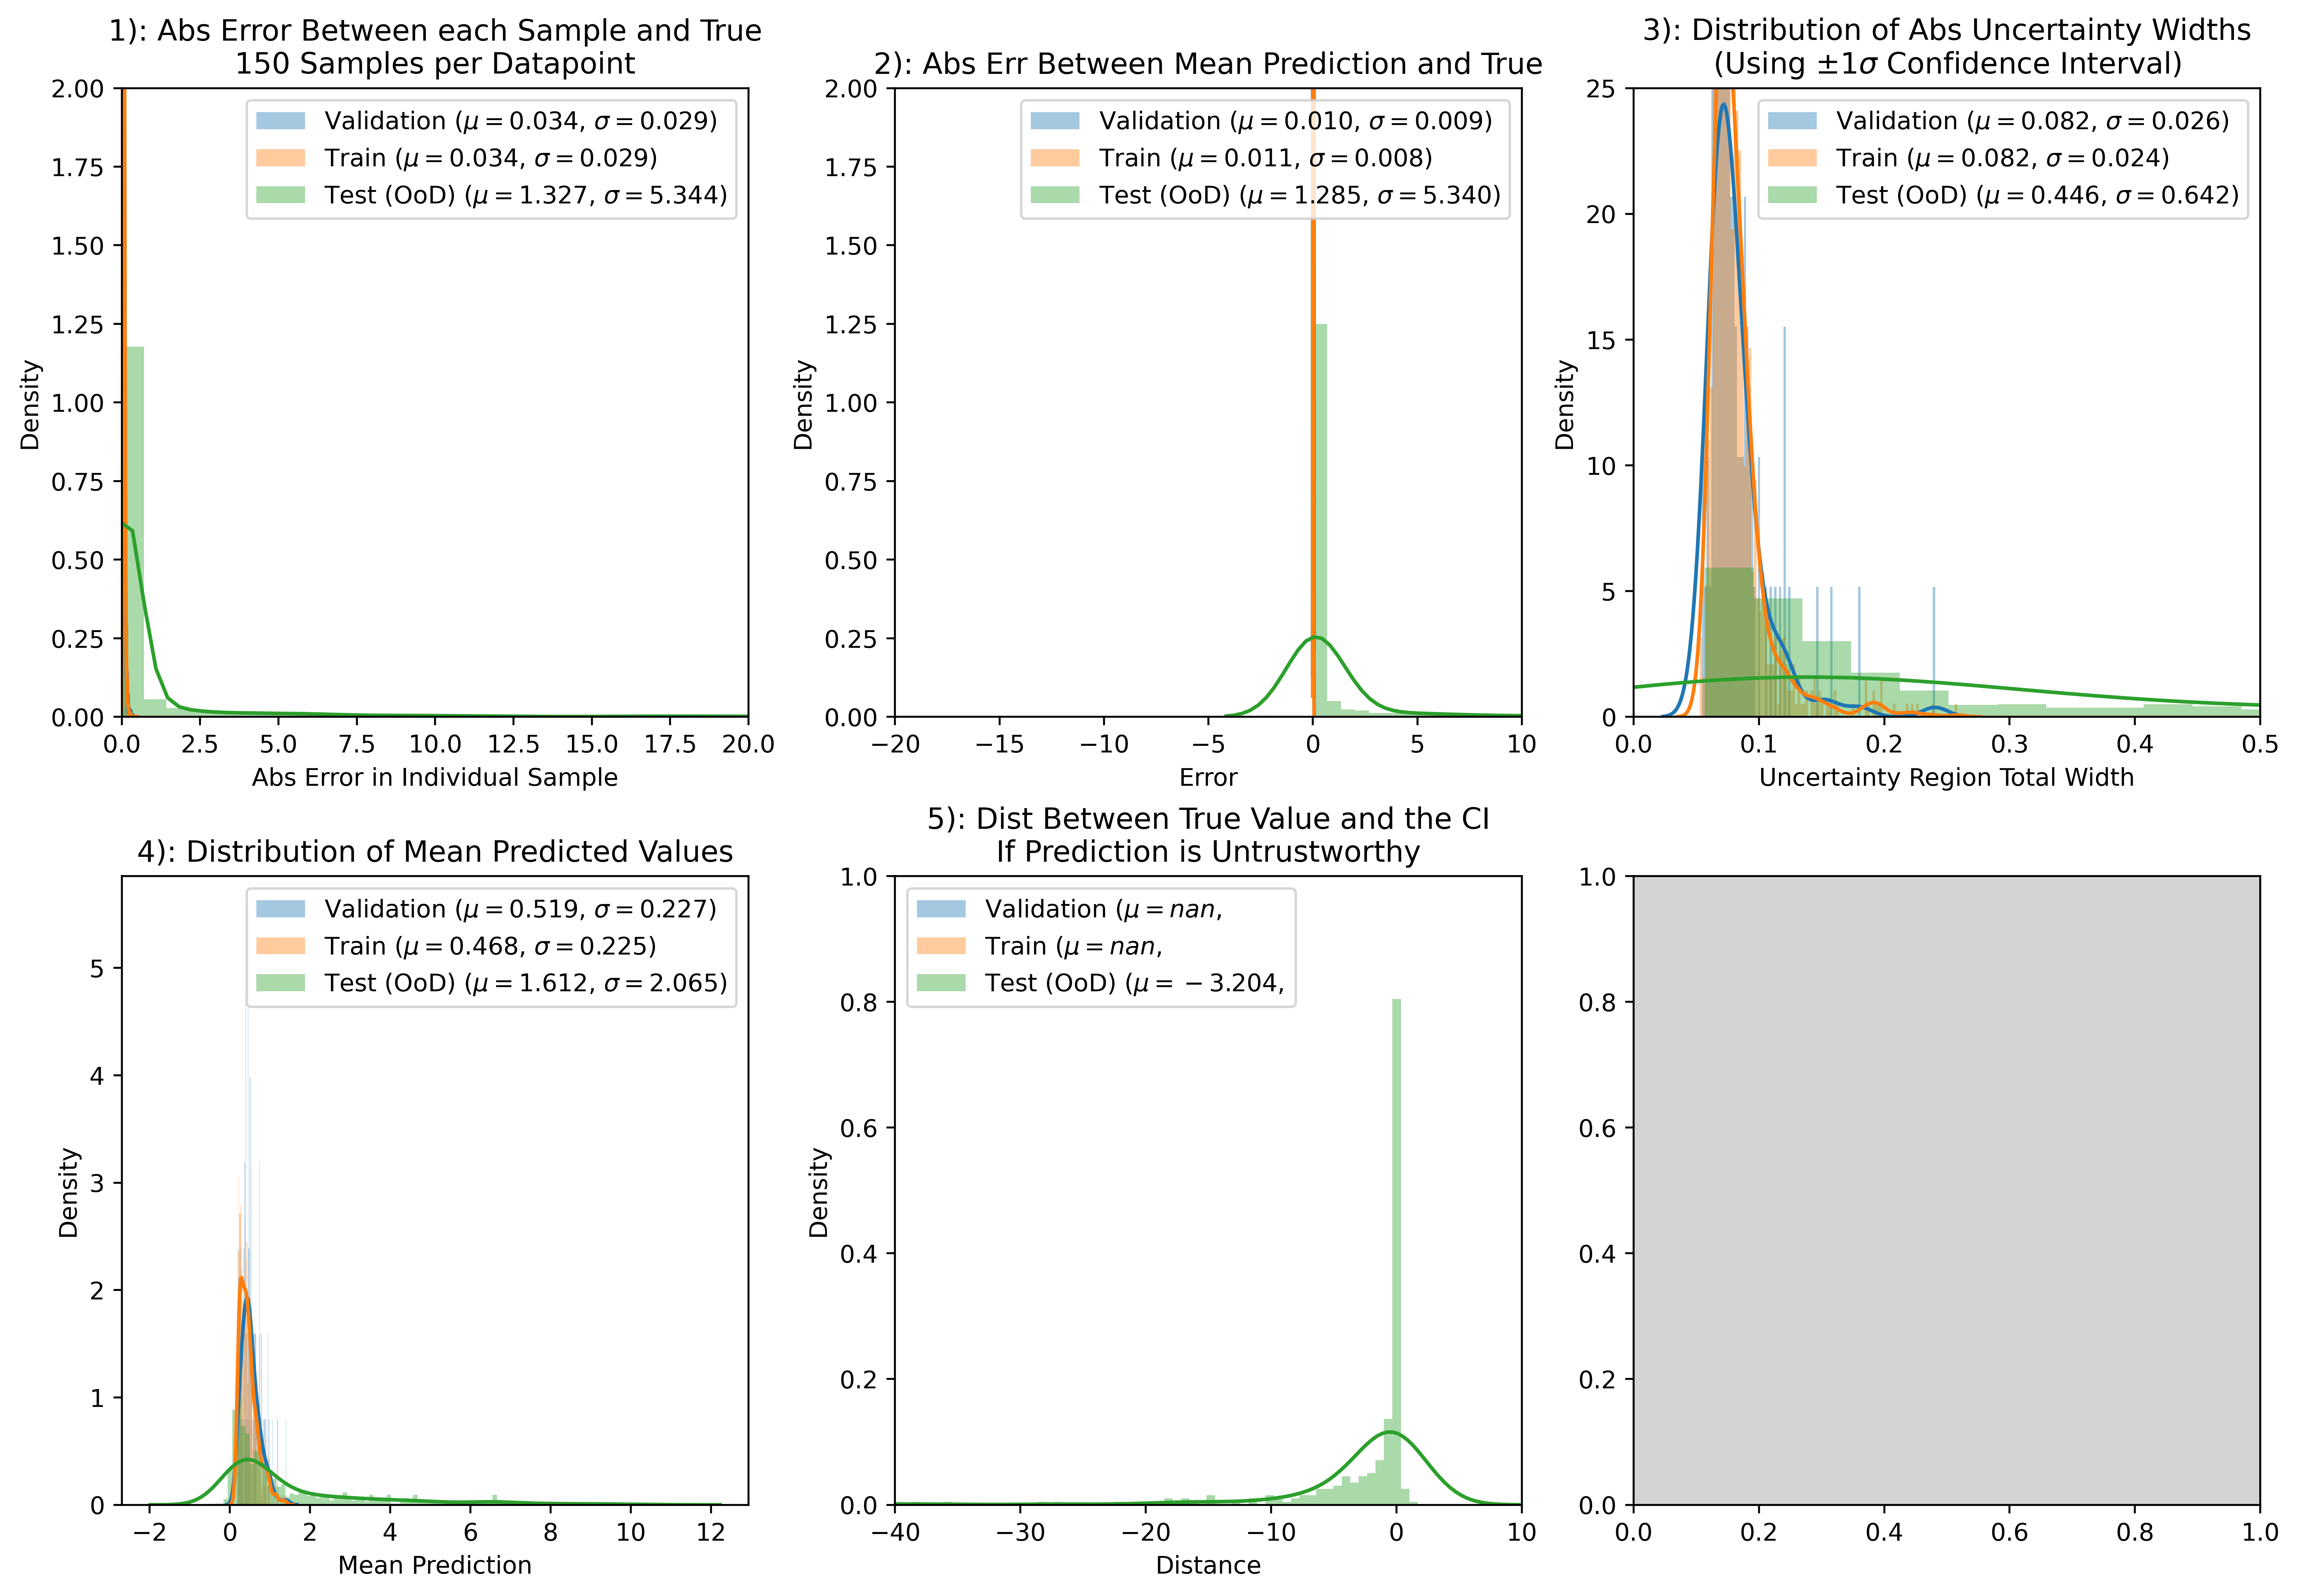

In [26]:
%matplotlib inline
samples = [samples_val2, samples_train2, samples_test2]
true = [y_val_np2, y_train_np2, y_test_np2]
labels=["Validation", "Train", "Test (OoD)"]
histograms1, statistics1 = post.histogram_stats(samples,
                                                true,
                                                labels,
                                                method="SD",
                                                interval=1,
                                                dp=.3,
                                                bins=100,
                                                figsize=(13,9),
                                                plot_1_ylim=(0,2),
                                                plot_1_xlim=(0,20),
                                                plot_2_ylim=(0,2),
                                                plot_3_ylim=(0,25),
                                                plot_3_xlim=(0,0.5),
                                                plot_2_xlim=(-20,10),
                                                plot_5_ylim=(0,1),
                                                plot_5_xlim=(-40,10))
                                                

# Save the image to weights and biases
if wandb_mode: wandb.log({"Histograms_output0":wandb.Image(histograms1)})
if wandb_mode: wandb.log({"Data_output0":statistics1})
    
    
# Print the individual figures shown in the histograms
# import json
# print(json.dumps(statistics1, indent=6, default=str))

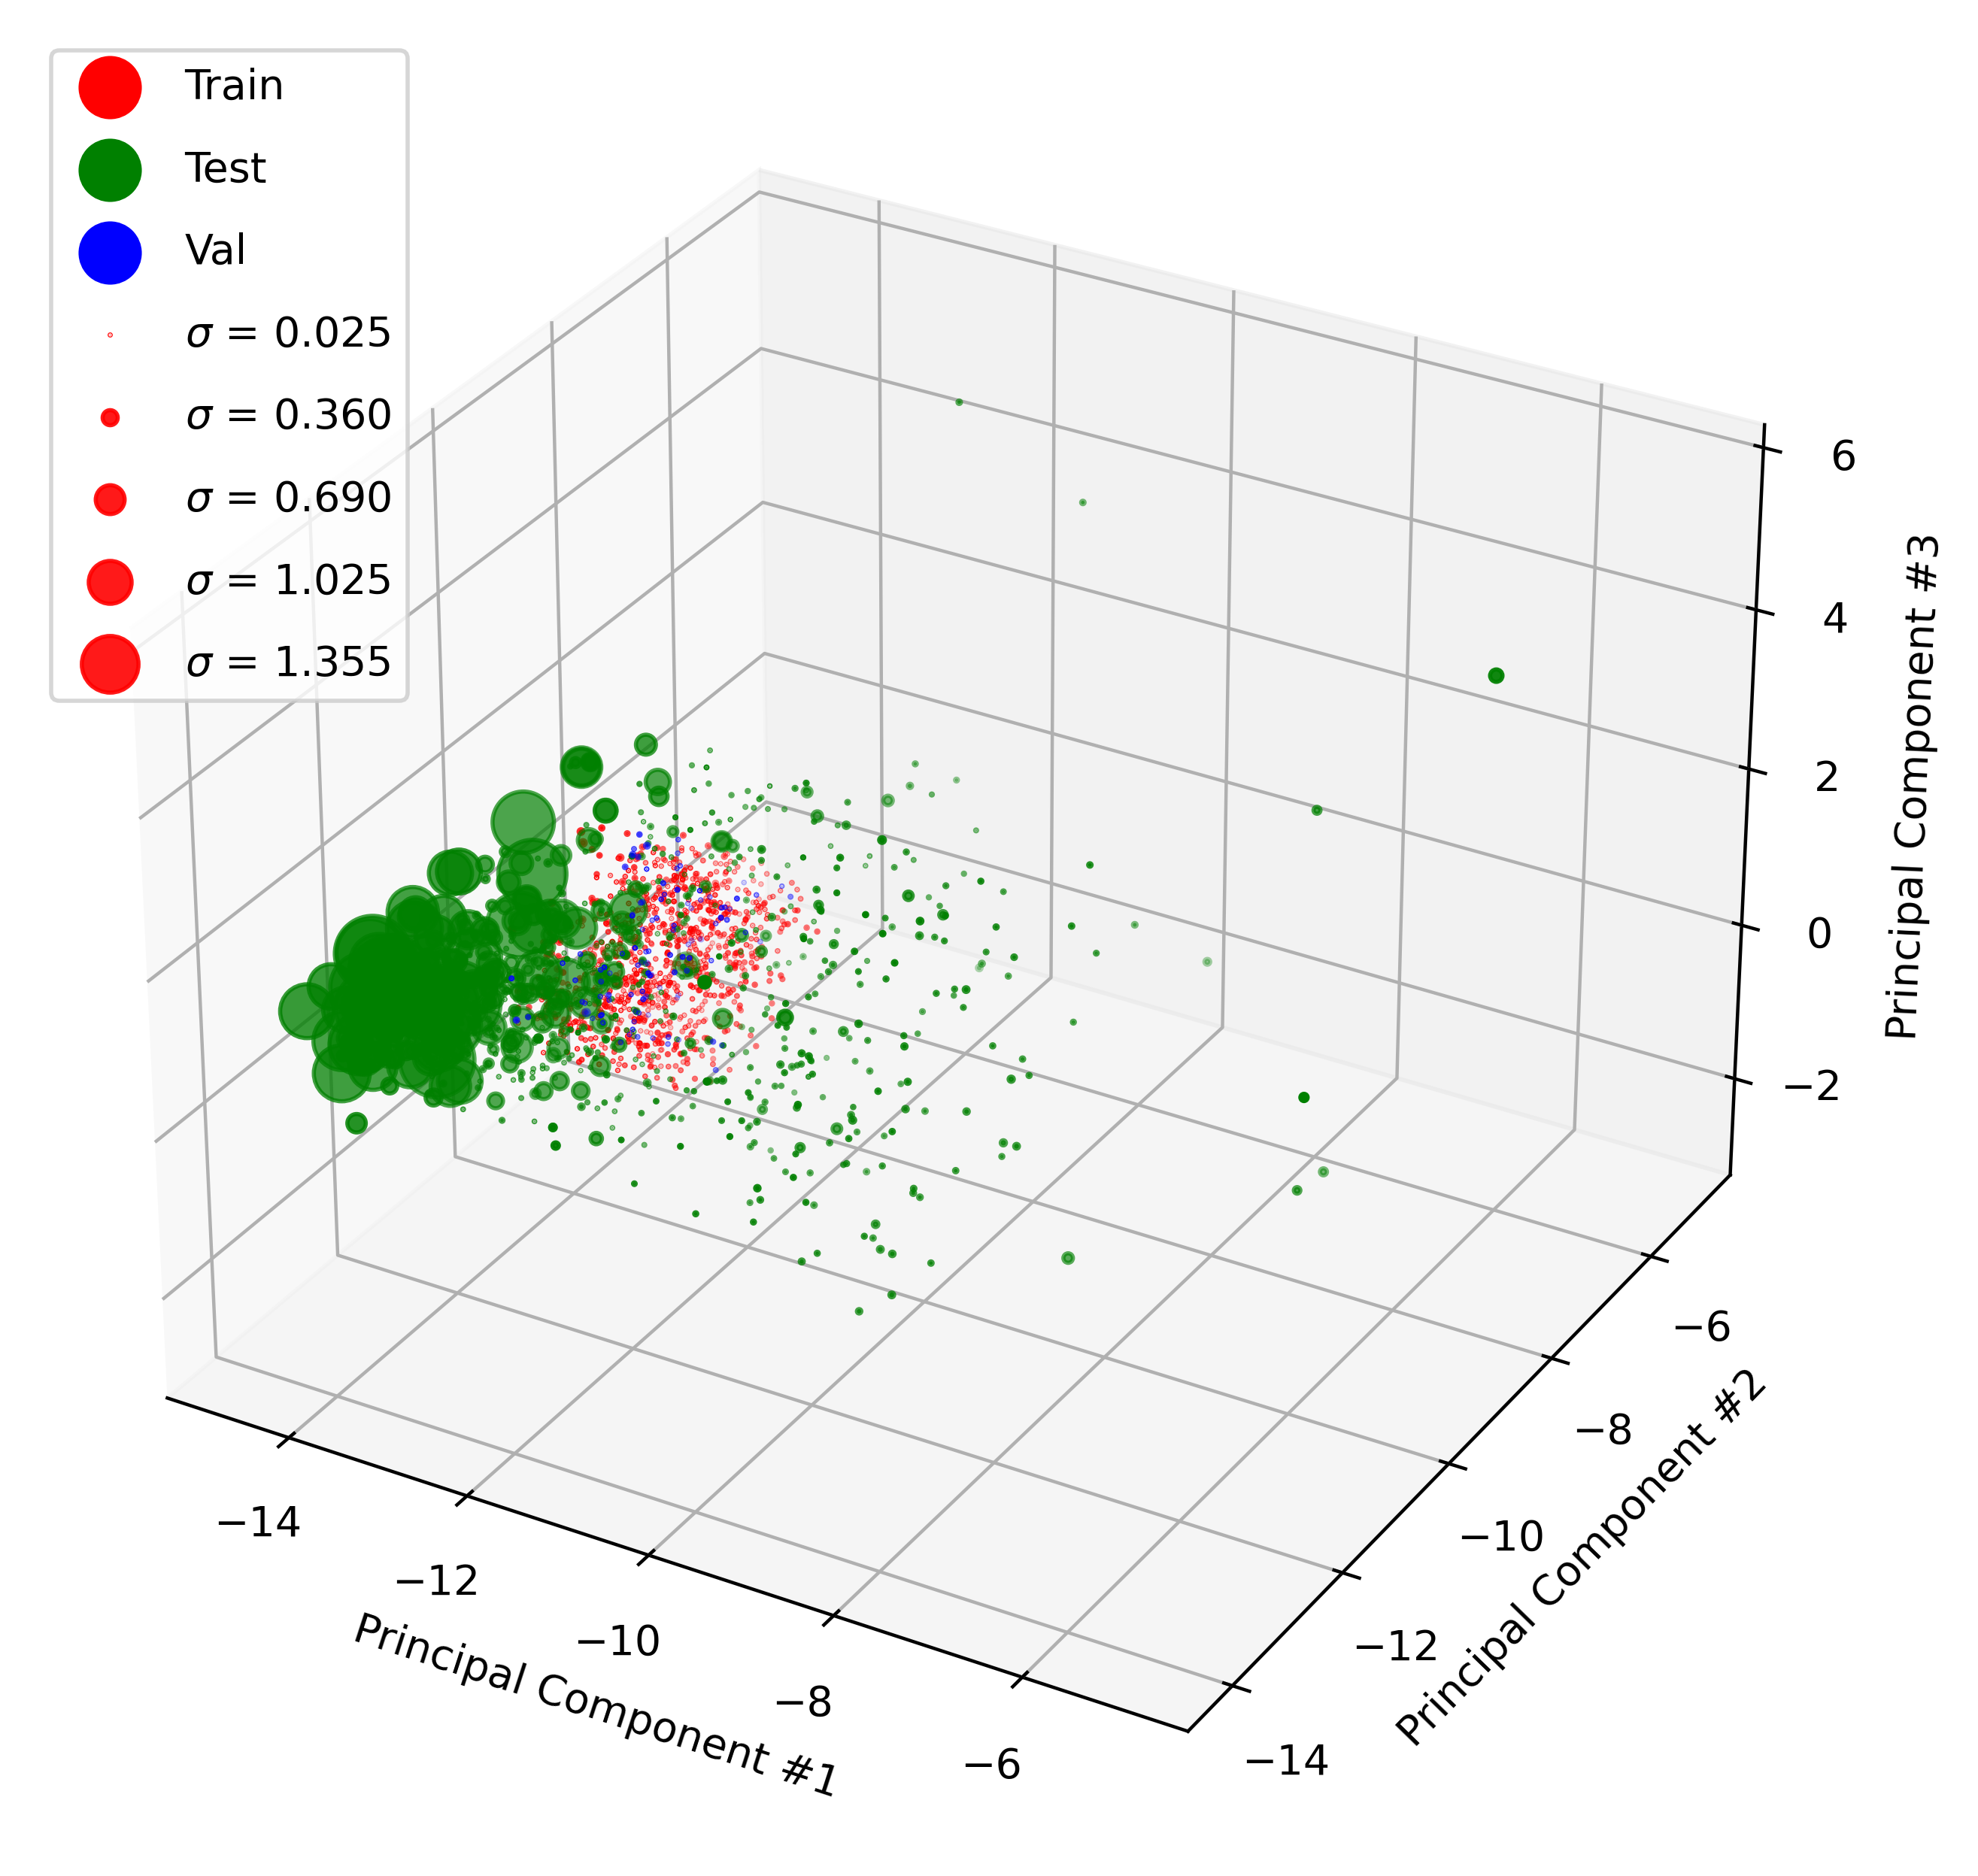

<Axes3DSubplot:xlabel='Principal Component #1', ylabel='Principal Component #2'>

In [27]:
#%matplotlib notebook
x_train_PCA = post.PCA_transformdata(x_train, components=components)
x_test_PCA = post.PCA_transformdata(x_test, components=components)
x_val_PCA = post.PCA_transformdata(x_val, components=components)

post.PCA_plot([x_train_PCA, x_test_PCA, x_val_PCA], 
              [stds_train2, stds_test2, stds_val2],
              labels=["Train", "Test", "Val"],
              output_num= 0,
              figsize=(8,8),
              scalingfactor=10,
              scalingpower=2,
              produce_animation=False,
              legend_num=5,
              legend_HDI=0.99,
              dpi = 400)

In [28]:
params = [[1, 20, 10], [1, 20, 10], [1, 50, 10], [5], [5], [5]]

# all_domain: Draws the cube that indicates the training domain. Same format as above.
all_domain = [[2., 15], [2., 15], [2., 15], [2., 15], [2., 15], [2., 15]]

num_samples=20               # How many forward passes to do per datapoint to get the posterior distribution
figsize = (10, 10)           # Figure size

means_pred, stds_pred, percent_uncert, xxx, yyy, zzz, labels, ranges, consts = post.generate_3d_samples(model,
                             params=params,
                             num_samples=num_samples)     # Optional, defualt=20

Variable parameter / axis labels = ['num_x', 'num_y', 'num_z']
Cycling through 10*10*10 = 1000 options..


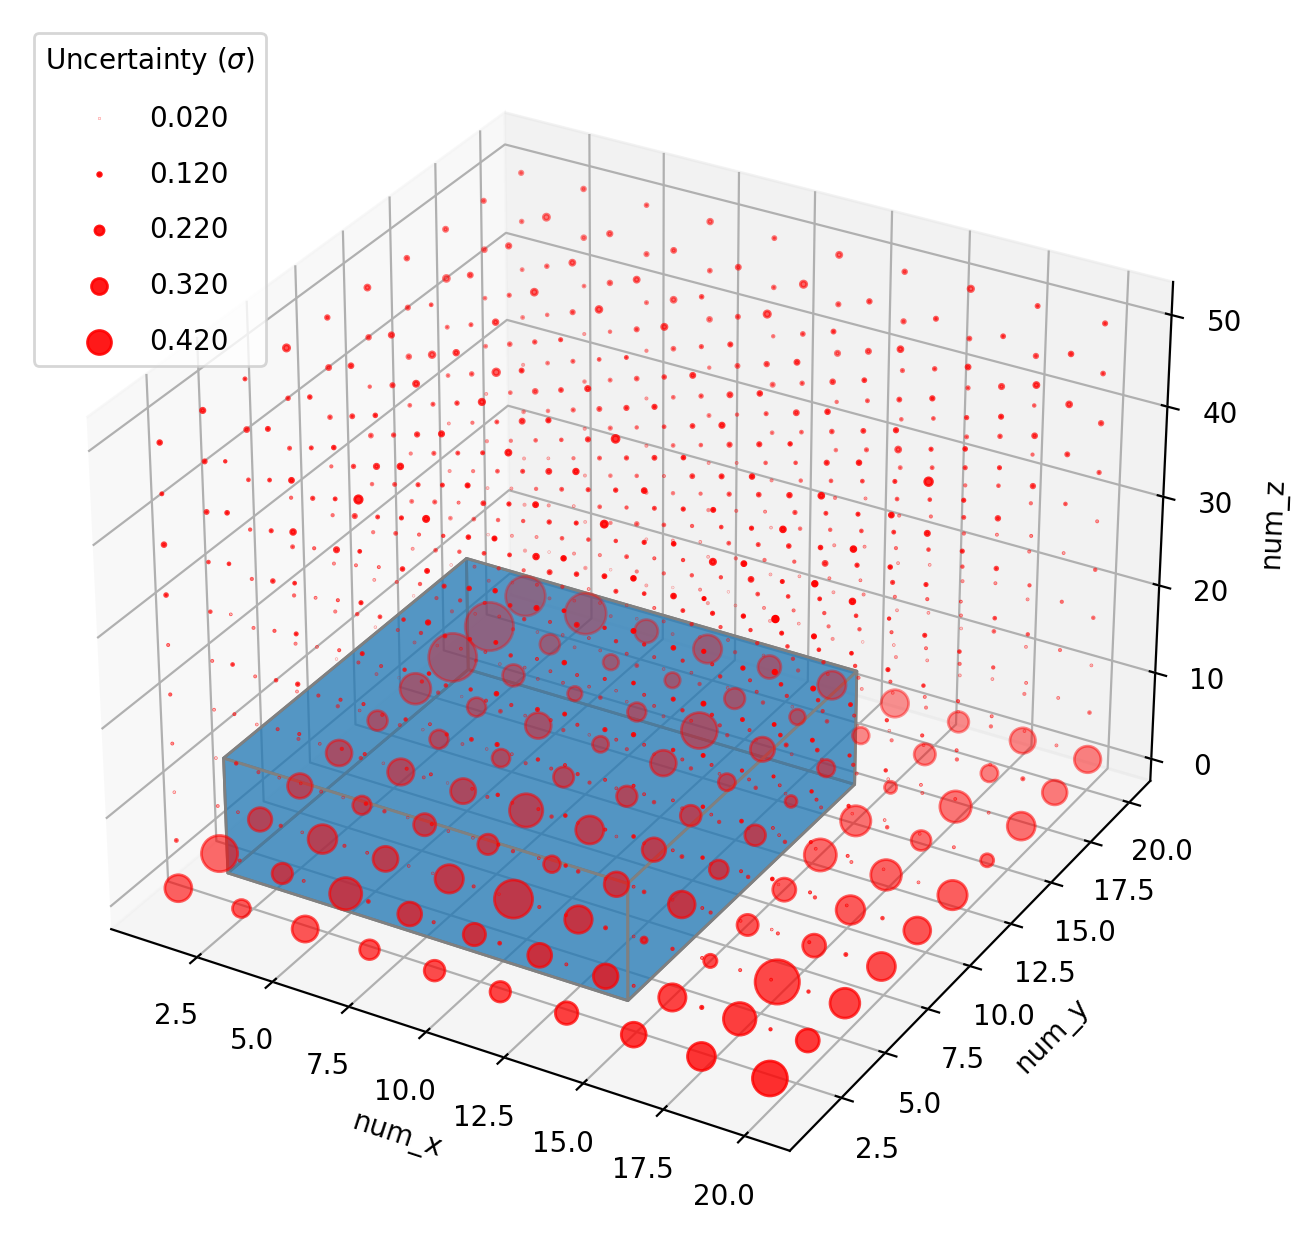

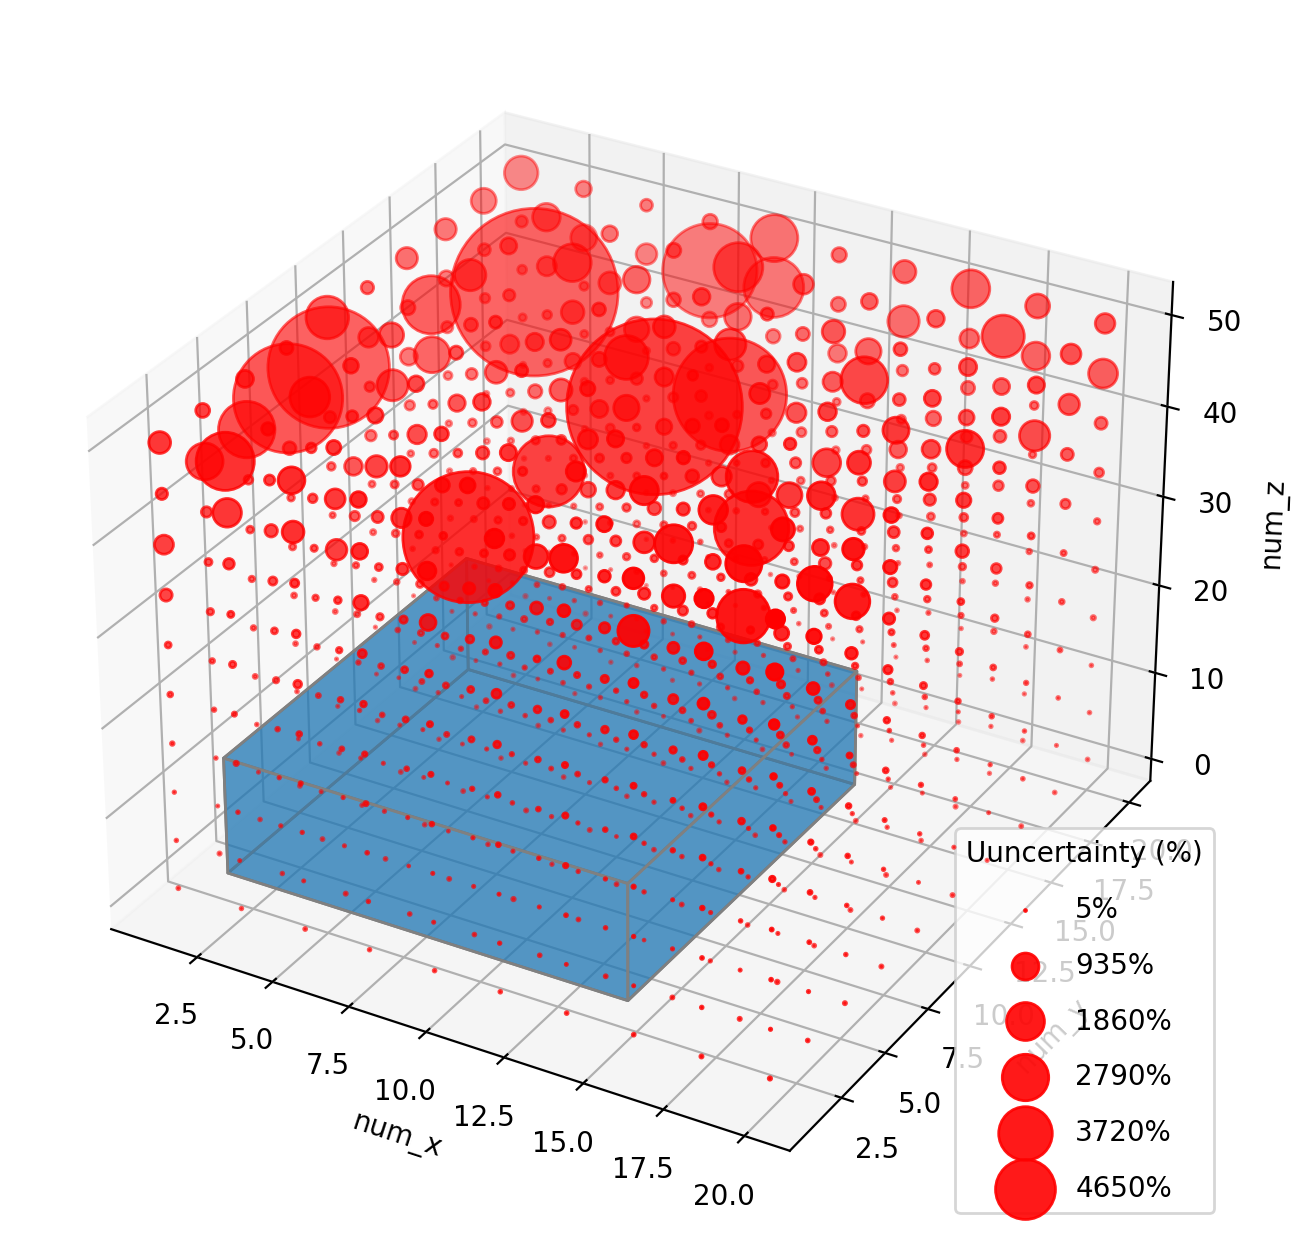

In [29]:
#%matplotlib inline  
post.generate_3d_plot(means_pred,                  # Mean prediction values of every point in cube
                 stds_pred,                   # Std of every point in cube
                 percent_uncert,              # Percent uncertainty every point in cube
                 xxx, yyy, zzz,               # Meshgrid for x, y and z
                 labels=labels,               # Labels for x, y and z axes. E.g. ["dim_x", "dim_y", "dim_z"]
                 ranges=ranges,               # Which parameter numbers are set as ranges
                 consts=consts,               # Which parameter numbers are constant
                 all_domain = all_domain,     # Draw the cube that represents the training domain
                 scale=False,                  # Scale all the axes to maintain relative size 
                 mode="absolute",             # "absolute": SD values. "relative": 100*(SD/mu). Default="absolute"
                 produce_animation=False,     # Default=False
                 animation_name="_.mp4",      # Default="./animation.mp4"
                 figsize=(8,8),             # Optional, default=(15,15)
                 scalingpower=3,              # Raise SD to this power when using "absolute" to scale size. Optional, default=3
                 scalingscalar=10)            # Multiply SD by this before raising to power. Optional, default=10

post.generate_3d_plot(means_pred,                  # Mean prediction values of every point in cube
                 stds_pred,                   # Std of every point in cube
                 percent_uncert,              # Percent uncertainty every point in cube
                 xxx, yyy, zzz,               # Meshgrid for x, y and z
                 ranges=ranges,               # Which parameter numbers are set as ranges
                 consts=consts,               # Which parameter numbers are constant
                 all_domain = all_domain,     # Draw the cube that represents the training domain
                 labels=labels,               # Labels for x, y and z axes. E.g. ["dim_x", "dim_y", "dim_z"]
                 scale=False,                 # Scale all the axes to maintain relative size 
                 mode="relative",             # "absolute": SD values. "relative": 100*(SD/mu). Default="absolute"
                 produce_animation=False,     # Default=False
                 animation_name="_.mp4",      # Default="./animation.mp4"
                 figsize=(8,8),             # Optional, default=(15,15)
                 scalingpower=2,              # Raise SD to this power when using "absolute" to scale size. Optional, default=3
                 scalingscalar=0.1,           # Multiply SD by this before raising to power. Optional, default=10
                 limit=4000,                  # What size to limit the point to (optional, default: 4000). Only for "relative" mode             
                 legend_num=6,                # How many legend entries to show
                 legend_HDI=0.99)             # HDI for setting upper and lower bound of legend

In [30]:
err_train3 = post.count_wrong_preds(samples_train3, y_train_np3, 1, "SD")
err_test3 = post.count_wrong_preds(samples_test3, y_test_np3, 1, "SD")
err_val3 = post.count_wrong_preds(samples_val3, y_val_np3, 1, "SD")

print(f"Train error:\t{np.sum(err_train3)}\tPREVIOUS:\t{np.sum(err_train)}")
print(f"Test error:\t{np.sum(err_test3)}\tPREVIOUS:\t{np.sum(err_test)}")
print(f"Val error:\t{np.sum(err_val3)}\tPREVIOUS:\t{np.sum(err_val)}")
print("----------------------")
print(f"Total error:\t{np.sum(err_train3)+np.sum(err_test3)+np.sum(err_val3)}")

NameError: name 'samples_train3' is not defined